<a href="https://colab.research.google.com/github/shoabahamed/kaggle_notebooks/blob/main/classification_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 909 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [230]:
# analysis
import pandas as pd
import numpy as np
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# processing
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StratifiedKfold
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
# from category_encoders import MEstimateEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import classification_report, accuracy_score, r2_score, mean_squared_error

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, mutual_info_regression, mutual_info_classif

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


import time
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras



# helper
from pathlib import Path
import warnings

warnings.filterwarnings('ignore') #supress warnings
sns.set(style='darkgrid') # set theme for plotting
pd.set_option('display.float_format', lambda x: '%.5f' % x)

<h2> WE WILL DO THE FOLLOWING THINGS IN ORDER</h2>

- Brief overview of the dataset
- Data Cleaning
- EDA
- Feature engineering
- spliting into train, validation dataset
- Missing Values
- Feature Selection
- Preprocessing
- find the best models
- use the best models to make prediction

****EDA, Feature Engineering or Missing values these three steps depends on person to person and project depended.****
****Normally you would do data cleaning for small dataset like these on spreadsheet but we will do data cleaning in python whenever we spot any unusal values or problems****

# DATASET OVERVIEW

In [4]:
# loading dataset

# path = Path('../input/predict-loan-amount-data/')
path = Path('/content/')
# path = Path('./files/')
# path = Path("/content/drive/MyDrive/loan prediction/")

train = pd.read_csv(path / 'train.csv')
test = pd.read_csv(path / 'test.csv')

train.head()

Customer ID               Name Gender  Age  Income (USD) Income Stability  \
0     C-36995   Frederica Shealy      F   56    1933.05000              Low   
1     C-33999  America Calderone      M   32    4952.91000              Low   
2      C-3770      Rosetta Verne      F   65     988.19000             High   
3     C-26480         Zoe Chitty      F   65           NaN             High   
4     C-23459       Afton Venema      F   31    2614.77000              Low   

  Profession     Type of Employment    Location  Loan Amount Request (USD)  \
0    Working            Sales staff  Semi-Urban                72809.58000   
1    Working                    NaN  Semi-Urban                46837.47000   
2  Pensioner                    NaN  Semi-Urban                45593.04000   
3  Pensioner                    NaN       Rural                80057.92000   
4    Working  High skill tech staff  Semi-Urban               113858.89000   

   ...  Credit Score No. of Defaults Has Active Credit Card  Property ID  \
0  ...     809.44000               0                    NaN          746   
1  ...     780.40000               0            Unpossessed          608   
2  ...     833.15000               0            Unpossessed          546   
3  ...     832.70000               1            Unpossessed          890   
4  ...     745.55000               1                 Active          715   

   Property Age  Property Type Property Location  Co-Applicant  \
0    1933.05000              4             Rural             1   
1    4952.91000              2             Rural             1   
2     988.19000              2             Urban             0   
3           NaN              2        Semi-Urban             1   
4    2614.77000              4        Semi-Urban             1   

   Property Price  Loan Sanction Amount (USD)  
0    119933.46000                 54607.18000  
1     54791.00000                 37469.98000  
2     72440.58000                 36474.43000  
3    121441.51000                 56040.54000  
4    208567.91000                 74008.28000  

[5 rows x 24 columns]

In [5]:
# cheking the datasets shape
train_rows, train_cols = train.shape[0], train.shape[1]
test_rows, test_cols = test.shape[0], test.shape[1]


print(f"The training dataframe has {train_rows} rows and {train_cols} cols")
print(f"The training dataframe has {test_rows} rows and {test_cols} cols")

The training dataframe has 30000 rows and 24 cols
The training dataframe has 20000 rows and 23 cols


In [6]:
# data types
print("TRAINING SET:\n")
display(train.dtypes)

print("\nTEST SET: \n")
display(test.dtypes)

TRAINING SET:



Customer ID                     object
Name                            object
Gender                          object
Age                              int64
Income (USD)                   float64
Income Stability                object
Profession                      object
Type of Employment              object
Location                        object
Loan Amount Request (USD)      float64
Current Loan Expenses (USD)    float64
Expense Type 1                  object
Expense Type 2                  object
Dependents                     float64
Credit Score                   float64
No. of Defaults                  int64
Has Active Credit Card          object
Property ID                      int64
Property Age                   float64
Property Type                    int64
Property Location               object
Co-Applicant                     int64
Property Price                 float64
Loan Sanction Amount (USD)     float64
dtype: object


TEST SET: 



Customer ID                     object
Name                            object
Gender                          object
Age                              int64
Income (USD)                   float64
Income Stability                object
Profession                      object
Type of Employment              object
Location                        object
Loan Amount Request (USD)      float64
Current Loan Expenses (USD)    float64
Expense Type 1                  object
Expense Type 2                  object
Dependents                     float64
Credit Score                   float64
No. of Defaults                  int64
Has Active Credit Card          object
Property ID                      int64
Property Age                   float64
Property Type                    int64
Property Location               object
Co-Applicant                    object
Property Price                  object
dtype: object

In [7]:
# mismatches data types
for col in train.columns:
    if col == 'Loan Sanction Amount (USD)':
        continue

    train_dtype = train[col].dtype
    test_dtype = test[col].dtype

    if train_dtype != test_dtype:
        print(col)

Co-Applicant
Property Price


some data types in test set does not match with the training dataset like-
* Co-Applicant, Property Price

or what they actually contain like -
* Property Type(contain integar values while it is actually categorical feataure)

In [8]:
# missing values
print('TRAINING SET MISSING VALUES: \n')
display(train.isnull().sum().sort_values(ascending=False))

print('\nTEST SET MISSING VALUES: \n')
display(test.isnull().sum().sort_values(ascending=False))

TRAINING SET MISSING VALUES: 



Type of Employment             7270
Property Age                   4850
Income (USD)                   4576
Dependents                     2493
Credit Score                   1703
Income Stability               1683
Has Active Credit Card         1566
Property Location               356
Loan Sanction Amount (USD)      340
Current Loan Expenses (USD)     172
Gender                           53
Property Price                    0
Co-Applicant                      0
Property Type                     0
Property ID                       0
Customer ID                       0
No. of Defaults                   0
Name                              0
Expense Type 1                    0
Loan Amount Request (USD)         0
Location                          0
Profession                        0
Age                               0
Expense Type 2                    0
dtype: int64


TEST SET MISSING VALUES: 



Type of Employment             4689
Dependents                     1142
Has Active Credit Card         1076
Property Age                    892
Income Stability                813
Income (USD)                    750
Credit Score                    743
Property Location               160
Current Loan Expenses (USD)      83
Gender                           31
Customer ID                       0
No. of Defaults                   0
Co-Applicant                      0
Property Type                     0
Property ID                       0
Expense Type 1                    0
Expense Type 2                    0
Name                              0
Loan Amount Request (USD)         0
Location                          0
Profession                        0
Age                               0
Property Price                    0
dtype: int64

In [9]:
train_cells, test_cells = (train_rows * train_cols), (test_rows * test_cols)
train_missing = train.isnull().sum().sum()
test_missing = test.isnull().sum().sum()

print(f"Missing values in train set {round((train_missing / train_cells) * 100, 3)}%")
print(f"Missing values in train set {round((test_missing / test_cells) * 100, 3)}%")

Missing values in train set 3.481%
Missing values in train set 2.256%


Not all columns has null values and percentage of null values are also low in train and test set

****checking for duplicates****

In [10]:
#  checking for duplicated rows
train.duplicated(keep=False).sum()

0

In [11]:
train_duplicates = train.duplicated(subset=['Customer ID'], keep='first')
test_duplicates = test.duplicated(subset=['Customer ID'], keep='first')

print(f'There are {train_duplicates.sum()} is the training dataset')
print(f'There are {test_duplicates.sum()} is the test dataset')

There are 0 is the training dataset
There are 0 is the test dataset


****checking cardiniality****
<br>Generally too many cardiniality(unique values) in a feature is not good for making predictions as too many unique category means less examples for each unique value. So models can not learn from each category. Moreover if we use a feature with high cardinality and one hot encode it there would be too many new features created

In [12]:
train.nunique().sort_values(ascending=False)

Customer ID                    30000
Name                           30000
Loan Amount Request (USD)      29982
Property Price                 29632
Income (USD)                   24429
Property Age                   24179
Current Loan Expenses (USD)    24041
Loan Sanction Amount (USD)     21450
Credit Score                   17586
Property ID                      999
Age                               48
Type of Employment                18
Dependents                        10
Profession                         8
Property Type                      4
Location                           3
Has Active Credit Card             3
Property Location                  3
Co-Applicant                       3
Expense Type 1                     2
Income Stability                   2
No. of Defaults                    2
Gender                             2
Expense Type 2                     2
dtype: int64

Many feature has high cardinality which was to be accepted as the features with high cardianility are mostly contain unique and continous values

****INSIGTS:****
  * There are enough data for trianing with 30000 observation
  * Co-Applicant, Property Price, Property Type data types do not match with what type of values they actually contain
  * There are not not that many missing values with only 3.5 percent of overall values missing in training set
  * There are null values in target <b>Loan Sanction Amount</b>
  * There are not duplicate rows in training dataset
  * Customer Id, Name can not be used to gain any information about target value as they contain unique values and can not be feature engineered to create new useful feature like we all already have Gender feature which could have been derieved from Name if Gender featrue was not already  present

****NOTES:****
  * Converty Co-Applicant, Property Price, Property Type to correct data type
  * Drop Name feature for now
  * Drop rows which has null in it's target values

# DATA CLEANING
We will identify the most common problems found in a dataset and solve them
* Searching for null values (completed in previous part)
* Mismatches Data types(completed in previous part)
* Misspelled words in columns values
* Mistyped values or unusual values
* Extra spaces
* Duplicates
* In consistent date formats
* any other problems

#We start will cleaning based on the insights gained in ****DATASET OVERVIEW**** step

In [13]:
columns = ['Property Price', 'Co-Applicant', 'Property Type']
test[columns].head()

Property Price Co-Applicant  Property Type
0       236644.5            1              2
1       142357.3            1              1
2      300991.24            1              1
3       125612.1            0              1
4       180908.0            1              4

Co-Applicant, Property Price are integar type values but they are object type one possible reason for it be that there are some string values in these column

In [14]:
test['Co-Applicant'].unique()

array(['1', '0', '?'], dtype=object)

In [15]:
test[test['Property Price'] == '?']['Property Price'].head()

22     ?
149    ?
356    ?
402    ?
403    ?
Name: Property Price, dtype: object

In [16]:
# Property Price and Co-Applicant has ?
# we need to replace wtih null first before converting them to int or float

test[['Property Price', 'Co-Applicant']] = test[['Property Price', 'Co-Applicant']].replace({"?": np.nan})
test[['Property Price', 'Co-Applicant']] = test[['Property Price', 'Co-Applicant']].astype('float')

In [17]:
train['Property Type'].unique()

array([4, 2, 1, 3])

<p>It seems that although Property Type is actually nominal categorical feature (categorical fetaure whose values do not have any rank)  they are recorded as discrete quantitive feature. So we will converty them to nominal categorical feature</p>

In [18]:
int_to_object = {1: "property_type_1", 2: "property_type_2", 3: "property_type_3",
                 4: "Property_type_4"}

train['Property Type'].replace(int_to_object, inplace=True)
test['Property Type'].replace(int_to_object, inplace=True)

In the previous module we also found out that there are null values in target column which need to be removed

In [19]:
train = train.dropna(subset=['Loan Sanction Amount (USD)'])

In [20]:
# dropping Name column in train and test
train.drop(columns=["Name"], inplace=True)
test.drop(columns=["Name"], inplace=True)

****misspelled words****

In [21]:
# checking if there are any misspelled words
columns = train.select_dtypes(include=['object']).columns

# for train
for col in columns:
    if col == "Customer ID":
        continue
    print(f"For train {col}: {train[col].unique()}")

print()
for col in columns:
    if col == "Customer ID":
        continue
    print(f"For test {col}: {test[col].unique()}")

For train Gender: ['F' 'M' nan]
For train Income Stability: ['Low' 'High' nan]
For train Profession: ['Working' 'Pensioner' 'State servant' 'Commercial associate' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
For train Type of Employment: ['Sales staff' nan 'High skill tech staff' 'Secretaries' 'Laborers'
 'Managers' 'Cooking staff' 'Core staff' 'Drivers' 'Realty agents'
 'Security staff' 'Accountants' 'Private service staff'
 'Waiters/barmen staff' 'Medicine staff' 'Cleaning staff'
 'Low-skill Laborers' 'HR staff' 'IT staff']
For train Location: ['Semi-Urban' 'Rural' 'Urban']
For train Expense Type 1: ['N' 'Y']
For train Expense Type 2: ['N' 'Y']
For train Has Active Credit Card: [nan 'Unpossessed' 'Active' 'Inactive']
For train Property Type: ['Property_type_4' 'property_type_2' 'property_type_1' 'property_type_3']
For train Property Location: ['Rural' 'Urban' 'Semi-Urban' nan]

For test Gender: ['F' 'M' nan]
For test Income Stability: ['Low' 'High' nan]
For test Professio

There doesn't appear to be any misspelled word. Although Location and Property Locations values are same they mean different things one is for where I live and another is for where is the location of my property

Income Stabilty, Location, Property Location, Has Active Credit Card can br  converted to ordered numbers as they are ordinal qualitive data</p>

****mistyped numbers****

To make it simple we will only check the range of the continous features

In [22]:
columns = train.select_dtypes(include=['float', int]).columns

# for train
for col in columns:
    max = train[col].max()
    min = train[col].min()
    print(f"For train feature {col} range is [{min} to {max}]")

print()
# for test
for col in columns:
    if col == "Loan Sanction Amount (USD)":
        continue
    max = test[col].max()
    min = test[col].min()
    print(f"For test feature {col} range is [{min} to {max}]")

For train feature Age range is [18 to 65]
For train feature Income (USD) range is [377.7 to 1777460.21]
For train feature Loan Amount Request (USD) range is [6048.24 to 621497.82]
For train feature Current Loan Expenses (USD) range is [-999.0 to 3840.88]
For train feature Dependents range is [1.0 to 14.0]
For train feature Credit Score range is [580.0 to 896.26]
For train feature No. of Defaults range is [0 to 1]
For train feature Property ID range is [1 to 999]
For train feature Property Age range is [377.7 to 1777460.21]
For train feature Co-Applicant range is [-999 to 1]
For train feature Property Price range is [-999.0 to 1077966.73]
For train feature Loan Sanction Amount (USD) range is [-999.0 to 481907.32]

For test feature Age range is [18 to 65]
For test feature Income (USD) range is [368.59 to 30427.68]
For test feature Loan Amount Request (USD) range is [6185.48 to 576335.68]
For test feature Current Loan Expenses (USD) range is [41.37 to 3305.97]
For test feature Dependents 

It seems that although the range for test dataset fetures are okay. Some features in training date set show some unsual values
* Current Loan Expenses (USD) - [-999.0 to 3840.88]
* Co-Applicant               - [-999 to 1]
* Property Price              - [-999.0 to 1077966.73]
* Loan Sanction Amount (USD)  - [-999.0 to 481907.32]


* Income (USD) & Property Age - [377.7 to 1777460.21] has same range in both train and test dataset which is very suspicious as they could be duplicate columns


****Finding unusal values and outlayers part is still not completed as they sometimes pretty hard to find. So we will search for layers in EDA part with the help of visualization and clean them****

In [23]:
train['Co-Applicant'].unique()

array([   1,    0, -999])

MY guess is that the -999 for first four features is probably a way of expressing null or a special value used only in that specific bank.

In [24]:
vars = ['Property Price','Co-Applicant','Current Loan Expenses (USD)','Loan Sanction Amount (USD)']
(train[vars] == -999).sum()

Property Price                 341
Co-Applicant                   165
Current Loan Expenses (USD)    174
Loan Sanction Amount (USD)     338
dtype: int64

Normally we would have asked the dataset creator about what these -999 represnts but since we have no way of doing that and we have 30000 training data we will just remove them from the training set to avoid any problem that might arise for filling them in

In [25]:
index_to_keep = (train[vars] != -999).all(axis=1)
train = train.loc[index_to_keep]

In [26]:
train.shape
# 28674, 23

(28674, 23)

The Income (USD) and Property Age has the same range lets look into that first

In [27]:
train[['Income (USD)', 'Property Age']].head()

Income (USD)  Property Age
0    1933.05000    1933.05000
1    4952.91000    4952.91000
2     988.19000     988.19000
3           NaN           NaN
4    2614.77000    2614.77000

In [28]:
train['Income (USD)'].equals(train['Property Age'])

False

It is telling us False which does not make sense since every values are equal. It could be due to null values

In [29]:
train[['Income (USD)', 'Property Age']].isnull().sum()

Income (USD)    4256
Property Age    4513
dtype: int64

It seems that althouh values are equal Income has more null values

In [30]:
(train['Income (USD)'] - train['Property Age']).sum()

0.0

Excluding the null values the two features are same

We can see that income (USD) and Property Age is actually same. Right now I would have questioned the authencity of the dataset but since the dataset came from machine learning competition it was probably done intentionally. Since the values does not look property Age it is probably Income (USD) values and Income (USD) has less null values. So we will drop Property Age for both training and test set to avoid any co-linearity

In [31]:
train.drop('Property Age', axis=1, inplace=True)
test.drop('Property Age', axis=1, inplace=True)

****extra spaces****

In [32]:
columns = train.select_dtypes(include=['object']).columns
train[columns].head(2)

Customer ID Gender Income Stability Profession Type of Employment  \
0     C-36995      F              Low    Working        Sales staff   
1     C-33999      M              Low    Working                NaN   

     Location Expense Type 1 Expense Type 2 Has Active Credit Card  \
0  Semi-Urban              N              N                    NaN   
1  Semi-Urban              N              Y            Unpossessed   

     Property Type Property Location  
0  Property_type_4             Rural  
1  property_type_2             Rural

In [33]:
# remove repeated spaces in all of the columns in the dataframe
# here \s+ means that select all those who which has on or more white sapces
train[columns].replace("\s+", " ", regex=True, inplace=True)
test[columns].replace("\s+", " ", regex=True, inplace=True)

In [34]:
# removeing leading and trailing white spaces
def remove_spaces(df, column):
    df[column] = df[column].str.strip()
    return df[column]

for col in columns:
    train[col] = remove_spaces(train, col)
    test[col] = remove_spaces(test, col)

****duplicates, Inconsistent data formats or anyother type of problem****

We have checked for duplicated rows in data overview part. Now will check for duplicated columns. But since we have already found duplicated columns while finding mistyped numbers we will skip these part. You can find how to find and remove duplicated columns in the article made by geeks for geeks below <a href=''>dsljf</a>

Since we do not have any date fetures in our dataset we will skip these part too and if any type of problem is found later we will fix them as we go through the project

****Even though our size of the training set has decreased from (30000, 23) to (28674, 22) we will get more accurate result and less hastle during the analyzing part.<br>Our dataset is still not fully cleared as we have missing values and probably outlayers which we will handle in the EDA and MISSING VALUES PART throught visualization****

In [35]:
train.shape

(28674, 22)

# EDA
* target feture analysis
* looking at continous categorical and gaining insight from them

*****since in our case we need to do regression and classfication both we will analyze for each problem separetly. We start by analyzing for regression model first since it is easier to spot outliers that way*****

## Analysing Target Variable

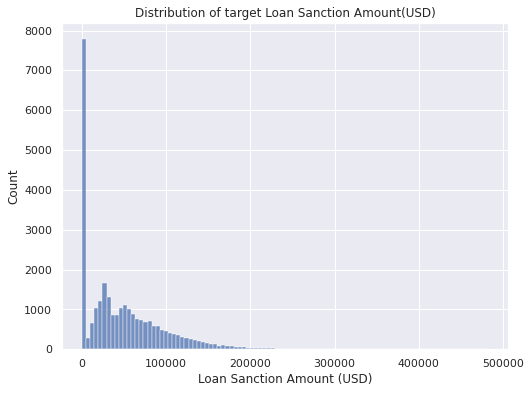

In [36]:
plt.figure(figsize=(8, 6))

target = train['Loan Sanction Amount (USD)']
sns.histplot(x=target)
plt.title('Distribution of target Loan Sanction Amount(USD)')
plt.show()

<p>A lot of the target values are Zero which indicates that they were not given any loan. We should see how our target distribution looks without zero</p>

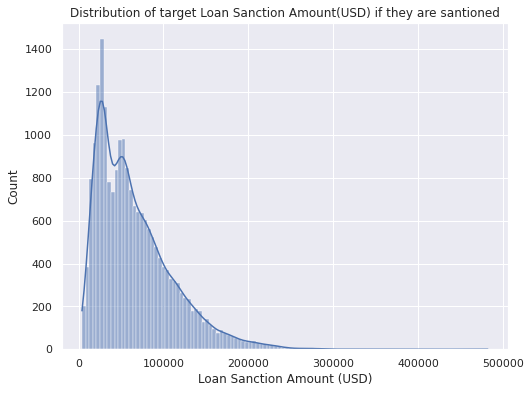

In [37]:
plt.figure(figsize=(8, 6))

sns.histplot(x=target[target>0], kde=True)
plt.title('Distribution of target Loan Sanction Amount(USD) if they are santioned')
plt.show()

In [38]:
target[target>0].describe()

count    20899.00000
mean     65929.41552
std      44896.39333
min       4023.18000
25%      30356.53500
50%      55177.65000
75%      89146.97000
max     481907.32000
Name: Loan Sanction Amount (USD), dtype: float64

In [39]:
print(f"The target has a skewness of {target.skew()}")
print(f"The target has a peakedness of {target.kurtosis()}")

The target has a skewness of 1.2276852265205898
The target has a peakedness of 1.7688603413820507


Acceptable range for skewness -  (-3 to +3)<Br>
Acceptable range for kurtosis -  (-10 to +10)

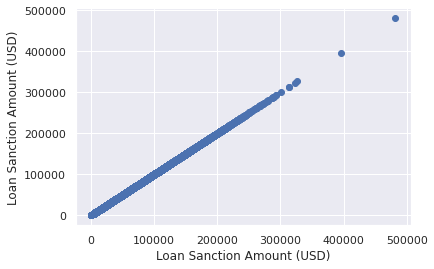

In [40]:
# looking for outlayers
plt.scatter(target, target)
plt.xlabel('Loan Sanction Amount (USD)')
plt.ylabel('Loan Sanction Amount (USD)')
plt.show()

We can do power transformation to reduce the skewness using different transformation like log, box-cox or johnson transformation

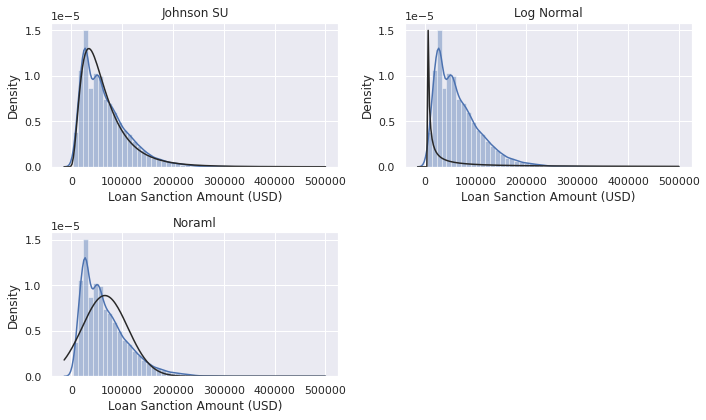

In [41]:
# remvoing 0 values to do transformation
target_without_zero = target[target > 0]

plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1);
sns.distplot(target_without_zero, fit=stats.johnsonsu)
plt.title('Johnson SU')

plt.subplot(2, 2, 2)
sns.distplot(target_without_zero, fit=stats.lognorm)
plt.title("Log Normal")

plt.subplot(2, 2, 3)
sns.distplot(target_without_zero, fit=stats.norm)
plt.title("Noraml")

plt.tight_layout()

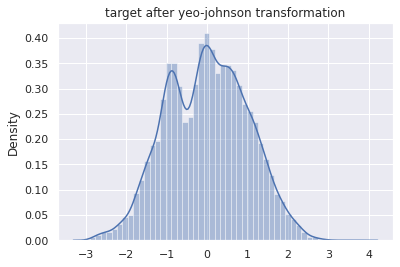

In [42]:
target_transformed = pd.Series(PowerTransformer().fit_transform(target_without_zero.to_frame()).flatten())

sns.distplot(x= target_transformed)
plt.title("target after yeo-johnson transformation")
plt.show()

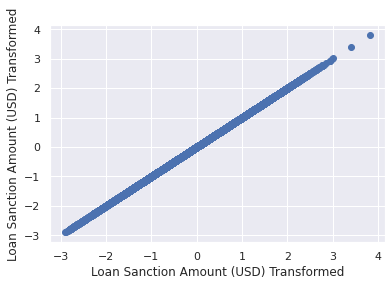

In [43]:
plt.scatter(target_transformed, target_transformed)
plt.xlabel('Loan Sanction Amount (USD) Transformed')
plt.ylabel('Loan Sanction Amount (USD) Transformed')
plt.show()

In [44]:
print(f"The target has a skewness of {target_transformed.skew()} after transformation")
print(f"The target has a peakedness of {target_transformed.kurtosis()} after transformation")

The target has a skewness of -0.02212240045783058 after transformation
The target has a peakedness of -0.48000818248513344 after transformation


****INSIGHTS:****
<BR>
* Target has a lot of zero values indicating no loan sanction
* The target show some skewness and peakedness and does not follow normal distribution
* There are 2 unusally high values in target features

****NOTES:****
<BR>
* We can log transformation or Johnson Transformation on target to normalize it
* We can handle zero inflated target variable by creating two models where classification model will predict if the person will have loan sanctioned or not and regression model would predict loan amount if they were given loan sanction. To do this we will create a feature we will predict if someone was given sanction or not

Before doing anything else we will create a feature on loan santioned or not

<br>
    You can find more about hadling zero inflated target from the article <a href='https://towardsdatascience.com/zero-inflated-regression-c7dfc656d8af'>Zero-Inflated Regression</a> by <b>Dr. Robert Kübler</b>

In [45]:
train['Loan Sanctioned'] = train['Loan Sanction Amount (USD)'] > 0

Loan Santioned feature target feature for classification and so we will anayliz it too

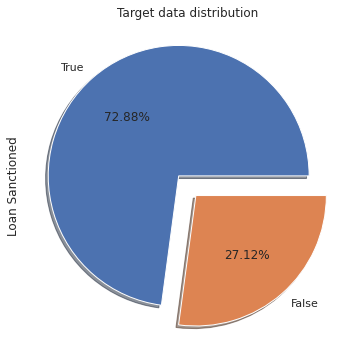

In [46]:
plt.figure(figsize=(8, 6))

train['Loan Sanctioned'].value_counts().plot(kind='pie', explode=[0.1, 0.1],
                                            autopct='%2.2f%%', shadow=True)

plt.title('Target data distribution')
plt.show()

****INSIGHTS:****
<BR>
* Loan Santioned target feature is not balanced

****NOTES:****
<br>
* May need to use sampling method to increase accuracy like oversampling, undersamplig, smothing etc

We are done with analyzing target variables now we will analyze continous data and see their relationship with both of the target variables

<H4>ANALYZING CONTINOUS DATA</H4>

- see basic overview
- plot distribution
- look for outliers
- what kind of relation with target can we infer from the scatterplot

****basic overview****

In [47]:
con_feats = train.select_dtypes(include=['float', 'int']).columns
info_cols = ['min', 'max', 'mean', '50%', 'std']

print("Training sets overview: ")
display(train[con_feats].describe().loc[info_cols])

Training sets overview: 


Age  Income (USD)  Loan Amount Request (USD)  \
min  18.00000     377.70000                 6048.24000   
max  65.00000 1777460.21000               621497.82000   
mean 40.12042    2633.19580                88842.82043   
50%  40.00000    2222.52000                75094.78500   
std  16.06254   11488.96023                59499.68400   

      Current Loan Expenses (USD)  Dependents  Credit Score  No. of Defaults  \
min                      33.76000     1.00000     580.85000          0.00000   
max                    3840.88000    14.00000     896.26000          1.00000   
mean                    409.23100     2.25410     740.06358          0.19394   
50%                     376.52000     2.00000     740.08500          0.00000   
std                     217.65967     0.95201      72.15044          0.39539   

      Property ID  Co-Applicant  Property Price  Loan Sanction Amount (USD)  
min       1.00000       0.00000      7265.95000                     0.00000  
max     999.00000       1.00000   1077966.73000                481907.32000  
mean    501.85262       0.85244    133294.28822                 48052.55127  
50%     504.00000       1.00000    111273.23000                 35842.39000  
std     288.12996       0.35466     92837.66828                 48251.10897

We can see that although mean and median are very close most of the time mean is generally greater than median indicating that there are outlayers present in training dataset feature

## Analyzing Features for Regression


### continous features

In [48]:
 # dataset with only loan Santioned amount greater zero to help analyzing
train_greater_than_zero = train[train['Loan Sanction Amount (USD)'] > 0]

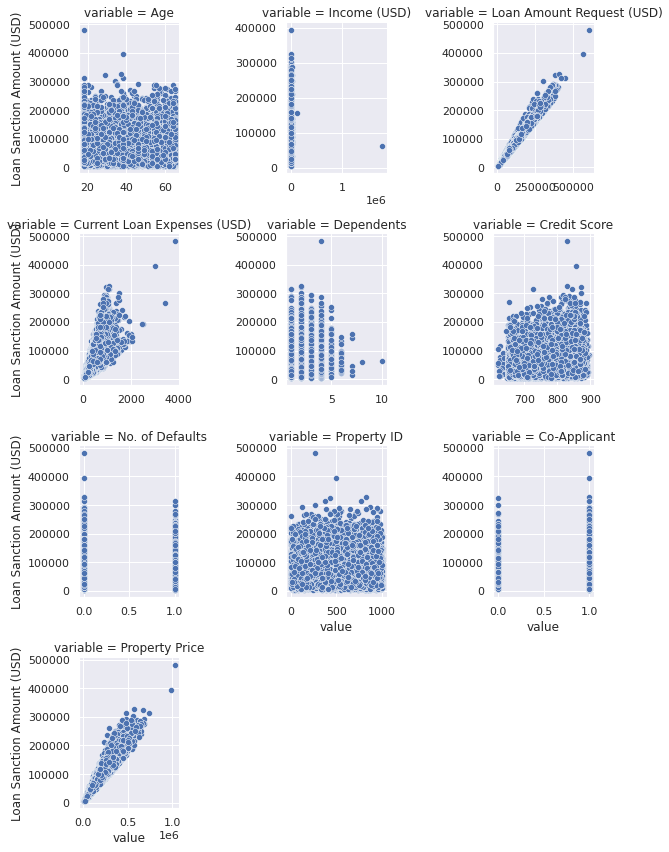

In [49]:
f = train_greater_than_zero.melt(value_vars=con_feats, id_vars=['Loan Sanction Amount (USD)'])
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, height=3)
g.map(sns.scatterplot, 'value', 'Loan Sanction Amount (USD)')
plt.show()

We can easily spot some outlayers in some features like Income (USD), Current Loan Expenses, Dependents. We will remove them but before that we will need to fill in the null values for these features as with something as comparing something will null values will give us false.

In [50]:
out_vars = ['Income (USD)', 'Current Loan Expenses (USD)', 'Dependents']
train[out_vars] = train[out_vars].fillna(-1) # filling in nulls with -1

filt = ((train['Income (USD)'] < 18000) & (train['Current Loan Expenses (USD)'] < 2500) )              # filtering out outlayers


train = train[filt]                          # filtered dataframe
train.replace({-1: np.nan}, inplace=True)    # replacing -1 with previous null

In [51]:
train_greater_than_zero=train[train['Loan Sanction Amount (USD)']>0] #updating traingreatetrhanzero

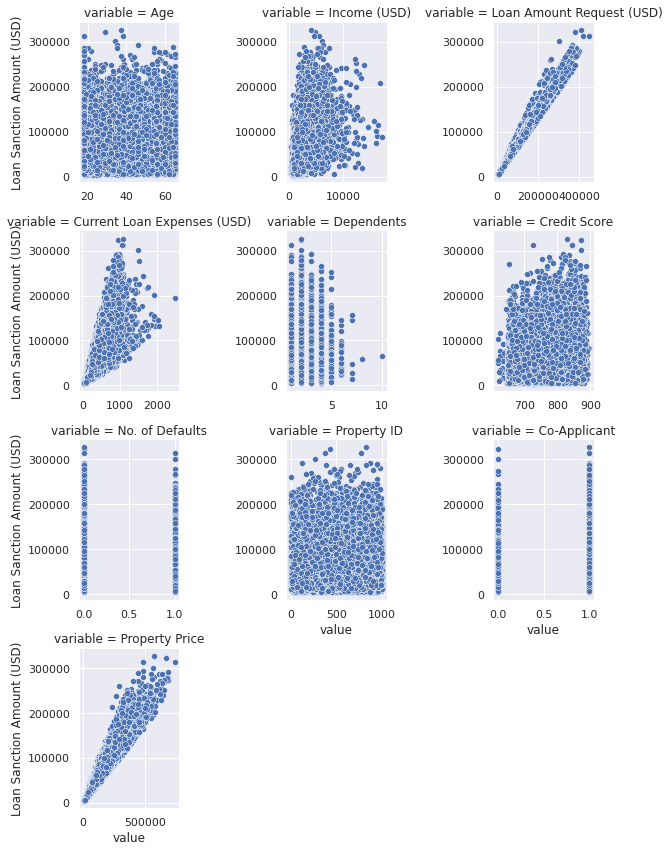

In [52]:
# after cleaning
f = train_greater_than_zero.melt(value_vars=con_feats, id_vars=['Loan Sanction Amount (USD)'])
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, height=3)
g.map(sns.scatterplot, 'value', 'Loan Sanction Amount (USD)')
plt.show()

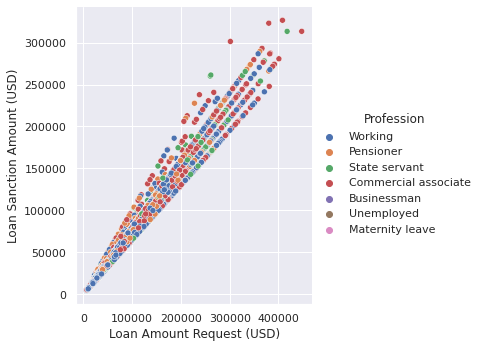

In [53]:
# JUST TESTING SOME RANDOM THINGS try and see if any combination works
# plt.figure(figsize=(15, 7))
sns.relplot(x='Loan Amount Request (USD)', y='Loan Sanction Amount (USD)', hue='Profession', data=train_greater_than_zero)

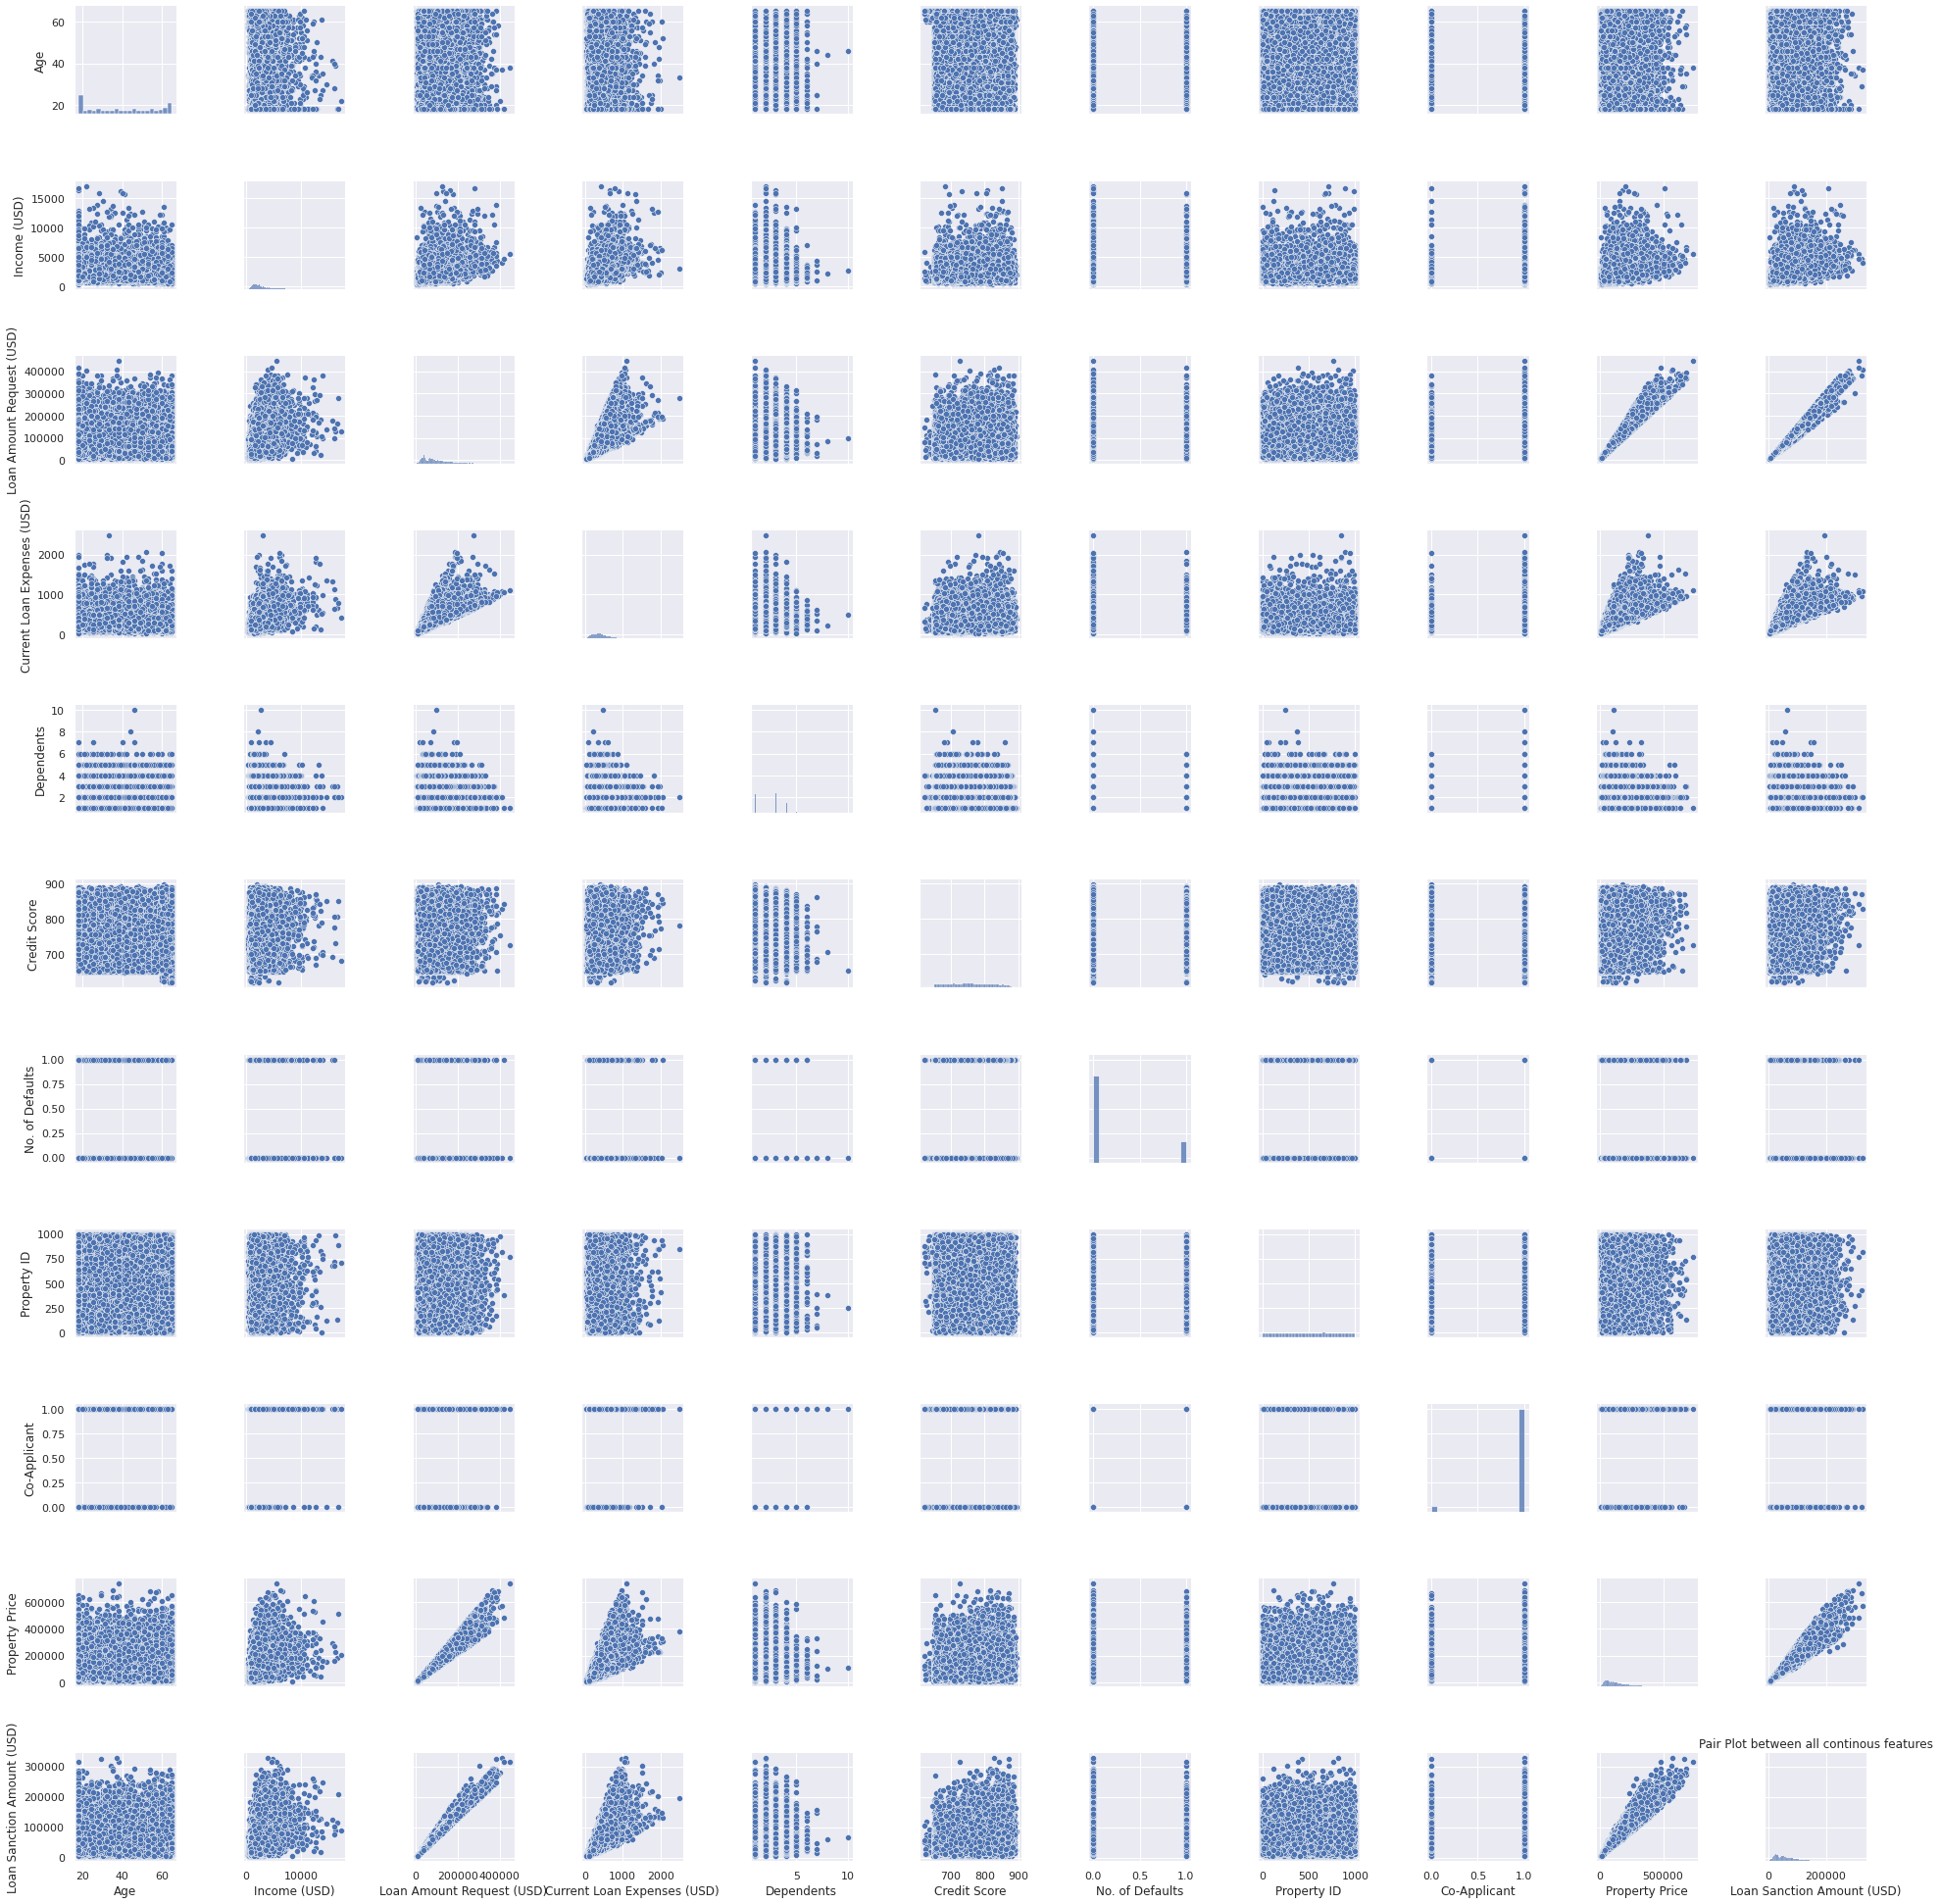

In [54]:
# overview for all continous features
sns.pairplot(train_greater_than_zero[con_feats])
plt.title("Pair Plot between all continous features")
plt.show()

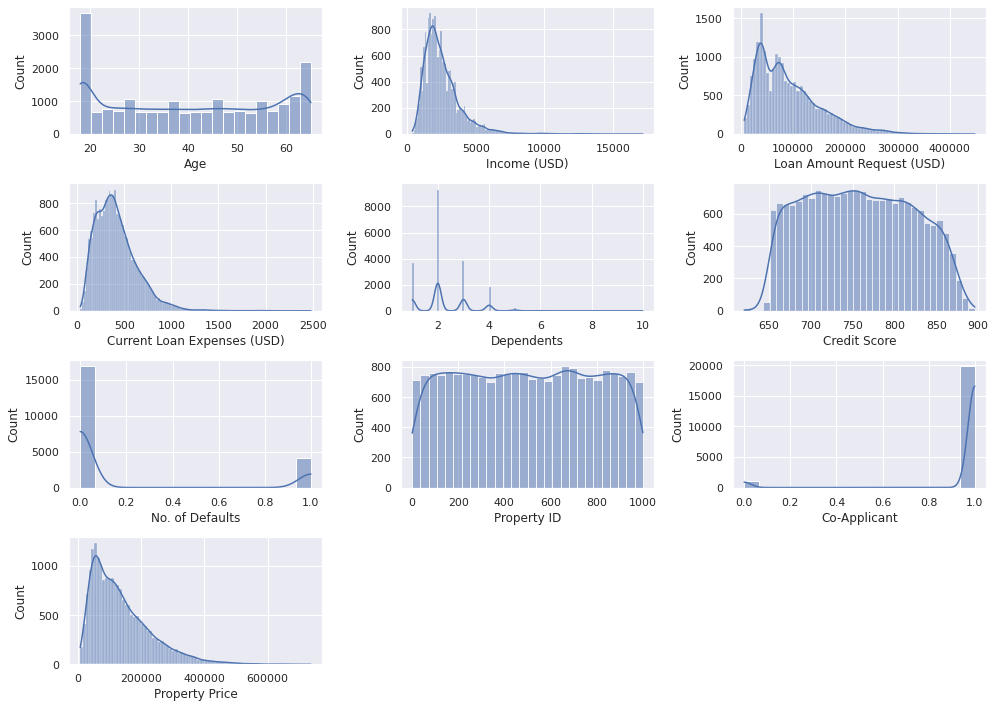

In [55]:
# to see distribution
plt.figure(figsize=(14, 10))
for index, col in enumerate(con_feats):
    if col == 'Loan Sanction Amount (USD)':
        continue

    plt.subplot(4, 3, index+1)
    sns.histplot(train_greater_than_zero[col], kde=True)


plt.tight_layout()

****INSIGHTS:****
<br>
* There are some outlayers present in Income (USD), Current Loan Expenses (USD), Dependents
* Most continous values does not have a normal distribution
* Age surprising does not show any relation with target

****NOTES:****
<br>
* <strike>Remove outlayers</strike>
* Applying log or other transformation for normal distriubtion on
  * Income (USD)
  * Loan Amount Request (USD)
  * Current Loan Expenses (USD)
  * Property Price
* Try feature engineering on feature likes Age which surprisingly does not show any relationship
* Try different feature engineering techniques on different features like adding Income + Property Price to find the net worth

### categorical features

In [56]:
# removing Customer ID for high cardianility
# removing Loan Sanctioned(target) as it is derived from Loan Sanction Amont (target) and
# only contain one category in train_greate_than_zero
cat_feats=train.drop(columns=['Customer ID', 'Loan Sanctioned']).select_dtypes(include=['object']).columns
train_greater_than_zero[cat_feats].head()

Gender Income Stability Profession     Type of Employment    Location  \
0      F              Low    Working            Sales staff  Semi-Urban   
1      M              Low    Working                    NaN  Semi-Urban   
2      F             High  Pensioner                    NaN  Semi-Urban   
3      F             High  Pensioner                    NaN       Rural   
4      F              Low    Working  High skill tech staff  Semi-Urban   

  Expense Type 1 Expense Type 2 Has Active Credit Card    Property Type  \
0              N              N                    NaN  Property_type_4   
1              N              Y            Unpossessed  property_type_2   
2              N              Y            Unpossessed  property_type_2   
3              N              Y            Unpossessed  property_type_2   
4              N              Y                 Active  Property_type_4   

  Property Location  
0             Rural  
1             Rural  
2             Urban  
3        Semi-Urban  
4        Semi-Urban

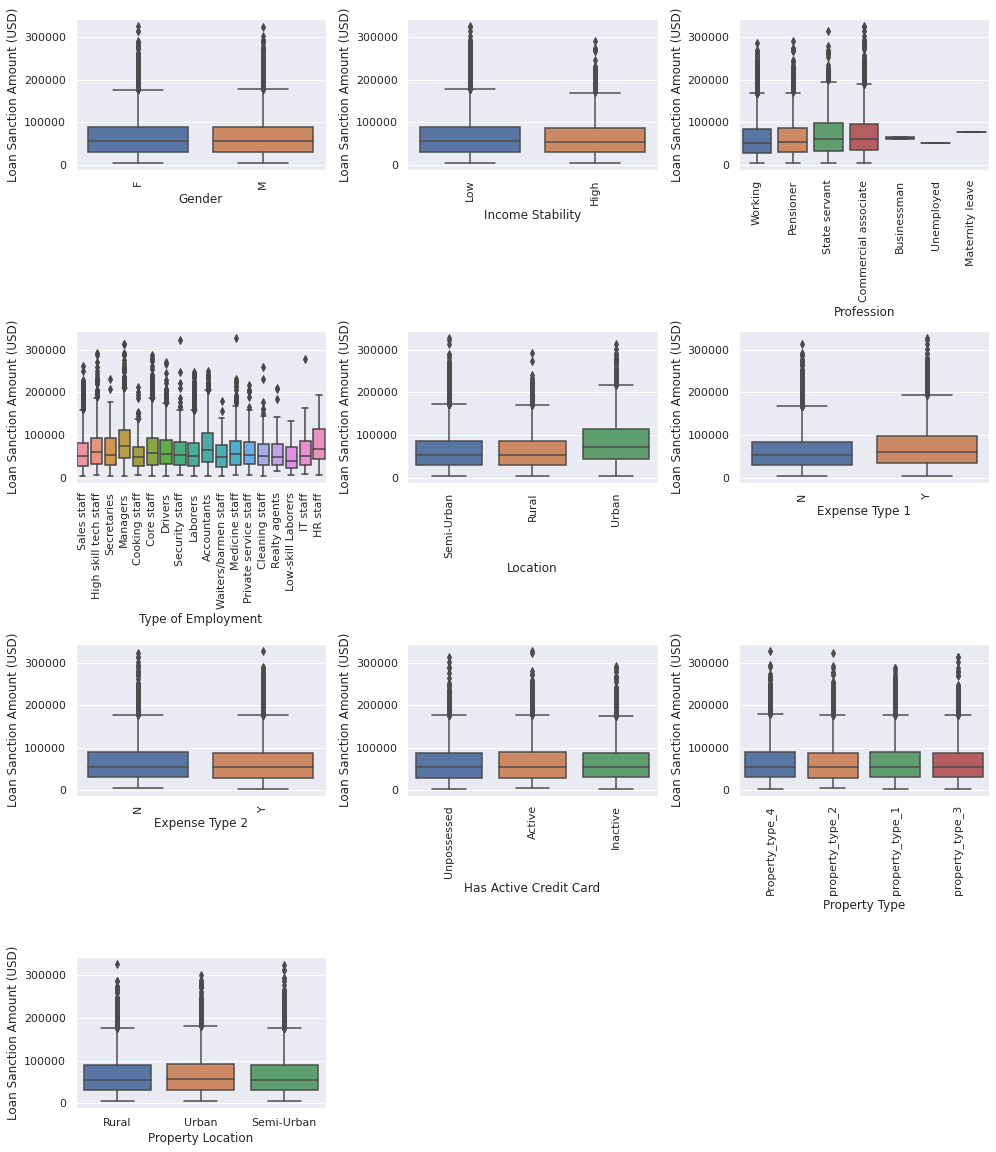

In [57]:
plt.figure(figsize=(14, 16))
for index, col in enumerate(cat_feats):
    plt.xticks(rotation=90)
    plt.subplot(4, 3, index+1)
    sns.boxplot(x=col, y='Loan Sanction Amount (USD)', data=train_greater_than_zero)

plt.tight_layout()

The Profession feature looks weird lets check that out

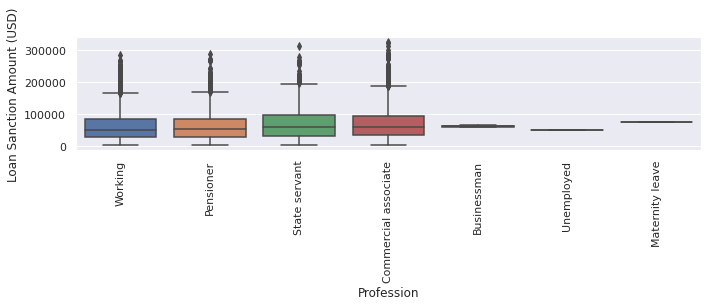

In [58]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='Profession', y='Loan Sanction Amount (USD)', data=train_greater_than_zero)
plt.xticks(rotation=90)
plt.tight_layout()

In [59]:
train_greater_than_zero['Profession'].value_counts()

Working                 11303
Commercial associate     5596
Pensioner                2279
State servant            1700
Businessman                 2
Unemployed                  1
Maternity leave             1
Name: Profession, dtype: int64

Some categories in Profession has very few observation we need to do something about them<br>
Although we can see some features which can be useful to regression but they are hardly any difference visibable. I t is because box plot alone can not tell the whole picture about data. We can try violin plot

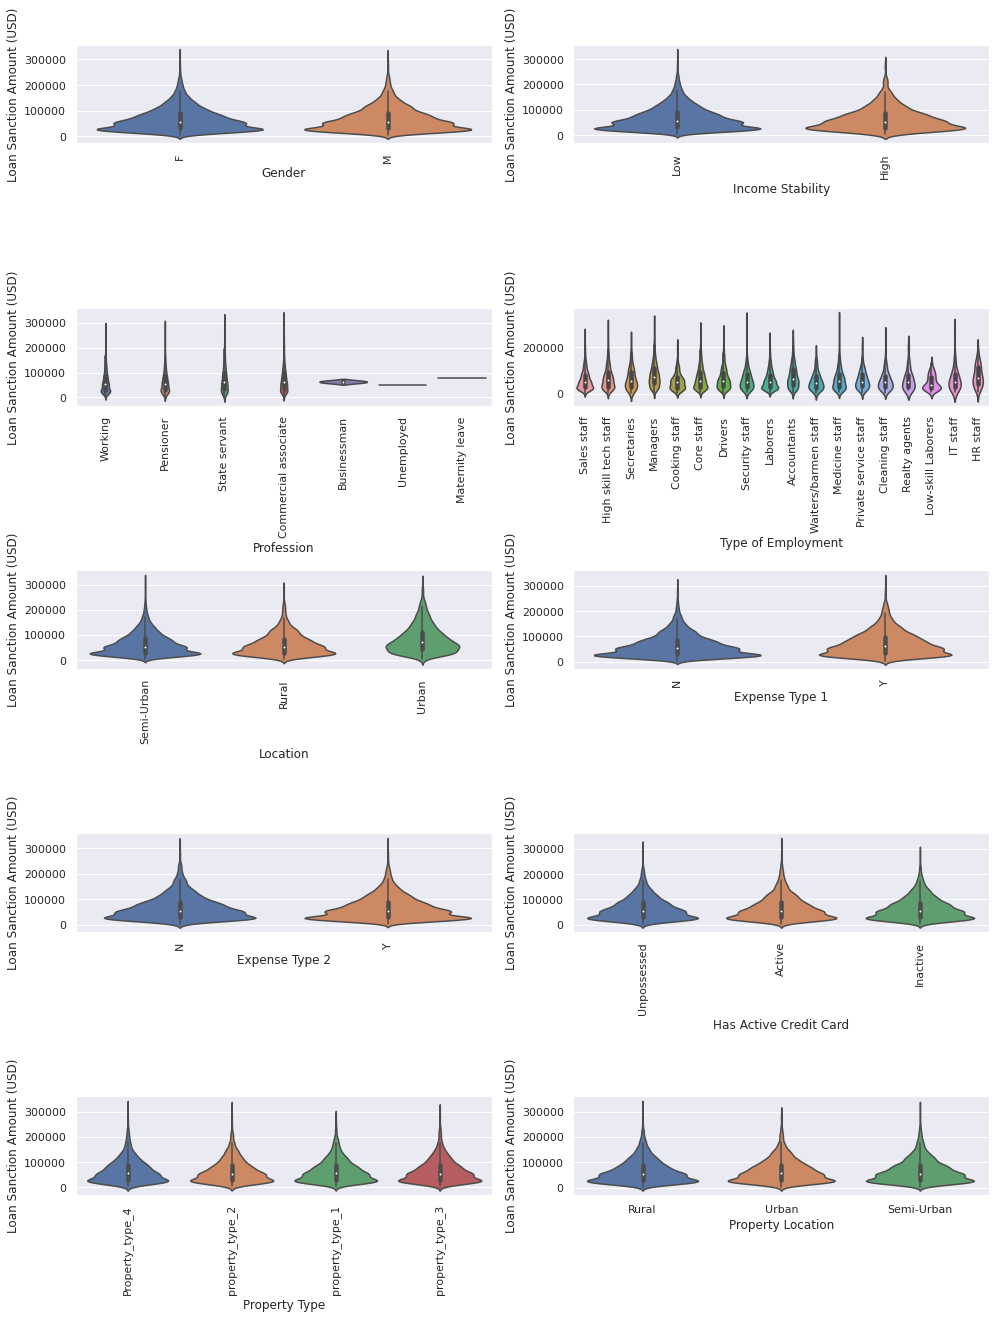

In [60]:
plt.figure(figsize=(14, 18))
for index, col in enumerate(cat_feats):
    plt.xticks(rotation=90)
    plt.subplot(5, 2, index+1)
    sns.violinplot(x=col, y='Loan Sanction Amount (USD)', data=train_greater_than_zero)

plt.tight_layout()

Even with violin plot it is hard to find useful features as every featrues categories has almost the same median and distribution or pdf. In simpler terms categories of a featrue can express variation of target feature meaning they are useless.
But Profession, Types of Employment, Location, Expense Types 1 and 2 seems like useful feature

So to find useful feature we will use <b>ANOVA<b/>.<br>
To learn more about feature selection with anova you can check this article <a href='https://towardsdatascience.com/anova-for-feature-selection-in-machine-learning-d9305e228476'>ANOVA for Feature Selection in Machine Learning</a> by <b>Sampath Kumar Gajawada</b>.
Khan Academy's video on Anova is very good and can be found in youtube <a href=''> khan academy</a>

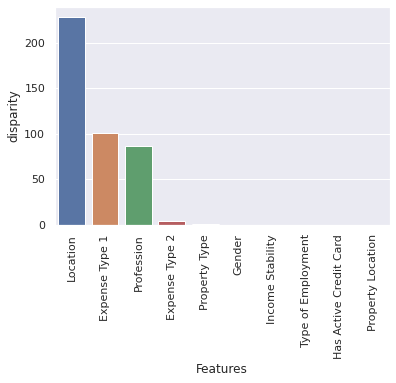

In [61]:
def anova(frame):
    anv = pd.DataFrame()
    anv['Features'] = cat_feats
    pvals = []
    for feats in anv['Features']:
        samples = []
        for category in frame[feats].unique():
            s = frame[frame[feats] == category]['Loan Sanction Amount (USD)'].values
            samples.append(s)

        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)

    anv['Pvals'] = pvals

    return anv.sort_values(by='Pvals')

a = anova(train_greater_than_zero)
a['disparity'] = np.log(1./a['Pvals'].values)
sns.barplot(data=a, x='Features', y='disparity')
plt.xticks(rotation=90)
plt.show()

Othe than Type of Employment Anova was able catch all those values which thought to be imporatnt

****INSIGHTS:****
<BR>
* Loan Sanction only has one categroy in train_greater_than_zero
* Most of the categorical features are  useless as they do not explain much variability in target feature other than Location, Expense Type, Profession, Type of Employment(was not able capture throught anova but was able identify from the violin)
* Profession Feature has few categories which has observations less than 5.

****NOTES:****
<BR>
* Do not use CustomerId and Loan Santioned when doing regression
* Keep all other features even if they may appear useless
* Filter out the other categories which has less than 5 observation from Profession Feature or group them into one category Other
* Add two Expenses feature and make them one new feature since they are related

## Analyzing for Classification
For classification we will analyze with a sample of the training set with equal amount True and False values in the target feature so that we can easily find realtion with other feature

In [62]:
# we do not need Loan Sanction Amount (USD) which is a target feature
train_clf = train.drop(columns=['Loan Sanction Amount (USD)'])

In [63]:
train_clf['Loan Sanctioned'].value_counts()

True     20882
False     7770
Name: Loan Sanctioned, dtype: int64

In [64]:
false_count = train_clf['Loan Sanctioned'].value_counts()[False]
train_true_sample = train_clf[train_clf['Loan Sanctioned'] == True].sample(false_count)
train_false_sample = train_clf[train_clf['Loan Sanctioned'] == False]

train_clf_sample = pd.concat([train_true_sample, train_false_sample])
train_clf_sample['Loan Sanctioned'].value_counts()

True     7770
False    7770
Name: Loan Sanctioned, dtype: int64

###categorical features</b>

In [65]:
plt.figure(figsize=(14, 16))
lenged = True
for index, col in enumerate(cat_feats):
    if col == 'Loan Santioned':
        continue
    plt.xticks(rotation=45)
    plt.subplot(6, 2, index+1)
    sns.countplot(x=col, hue='Loan Sanctioned', data=train_clf_sample)



plt.tight_layout()

****INSIGHTS:****
<Br>
* Stability, Profession, Type of Employment, Location, Expense Type, Property Location has an impact on Getting Loan
* Income Stability although a important featurer has very unbalanced data
* Gender, Property Location does not have impact on target

****NOTES****
* Location can converted to orderly categorical data


### continous features

In [66]:
con_feats = train_clf_sample.select_dtypes(include=['float', 'int']).columns

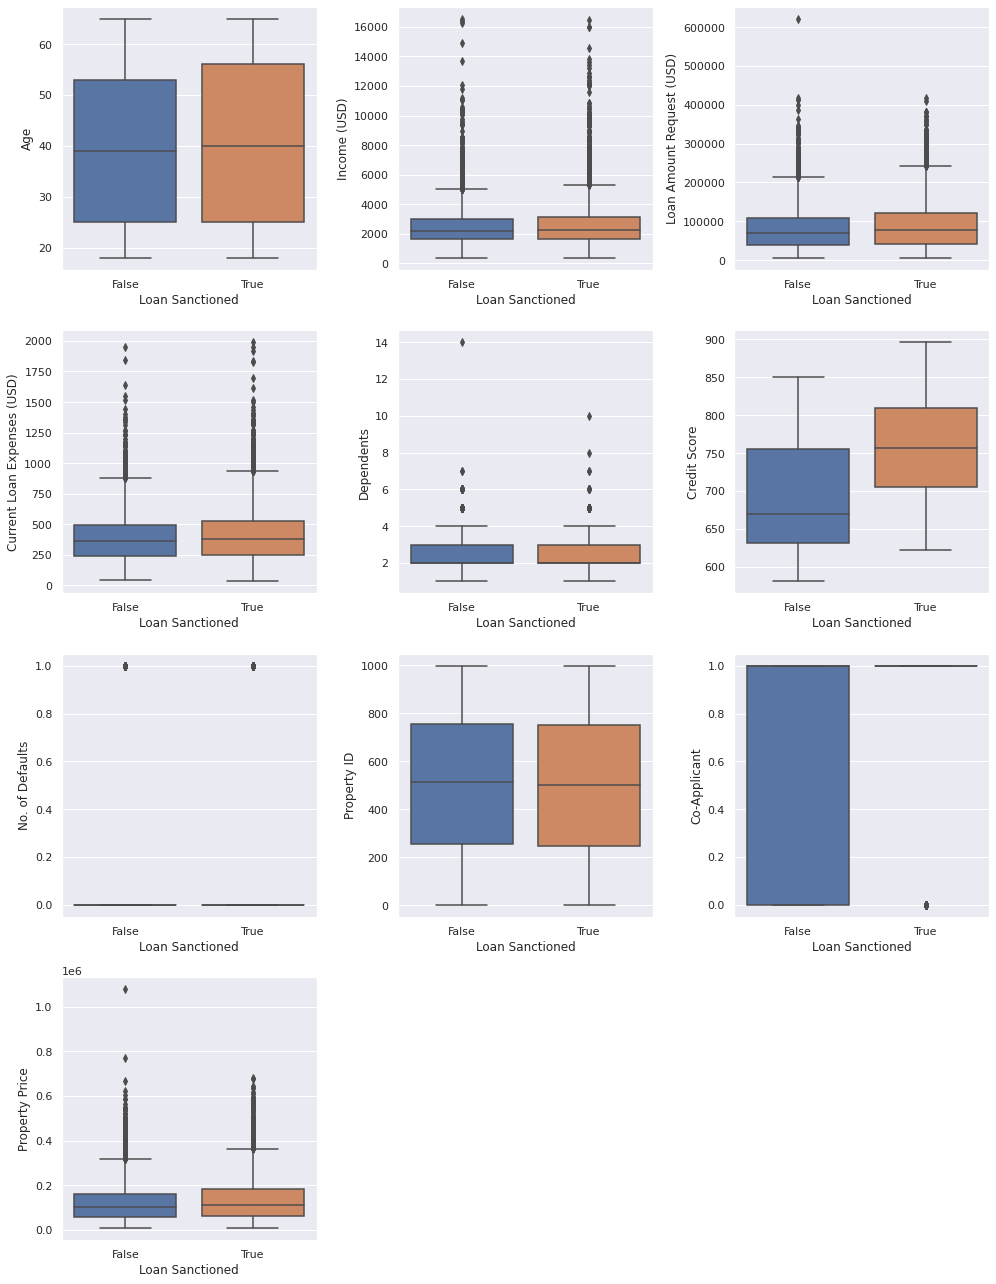

In [67]:
plt.figure(figsize=(14, 18))
for index, col in enumerate(con_feats):
    plt.subplot(4, 3, index+1)
    sns.boxplot(y=col, x='Loan Sanctioned', data=train_clf_sample)

plt.tight_layout()

Lets plot violin plot next to see distribution too

In [68]:
plt.figure(figsize=(14, 18))
for index, col in enumerate(con_feats):
    plt.subplot(4, 3, index+1)
    sns.violinplot(y=col, x='Loan Sanctioned', data=train_clf_sample)

plt.tight_layout()

At a glance we can see at a glance that Credit Score is very important while other has minor impact on the result. There also some features with unbalanced data like Co-Applicant, No. of Defaults

In [69]:
train_clf_sample['Co-Applicant'].value_counts()

1    11988
0     3552
Name: Co-Applicant, dtype: int64

In [70]:
co_app_count = pd.pivot_table(data=train_clf_sample, index='Co-Applicant', columns='Loan Sanctioned',
              values='Customer ID', aggfunc='count', margins=True)

co_app_count['False_perc'] = (co_app_count[False] / co_app_count['All']) * 100
co_app_count['True_perc'] = 100 - co_app_count['False_perc']
co_app_count

Loan Sanctioned  False  True    All  False_perc  True_perc
Co-Applicant                                              
0                 3184   368   3552    89.63964   10.36036
1                 4586  7402  11988    38.25492   61.74508
All               7770  7770  15540    50.00000   50.00000

From the privot table we can see that Co-applicant is very useful feature. But we were not able to capture it throught box plot while being able to capture it somewhat with violin plot. We will see if treating Co-Applicant as categorical feature has any impact

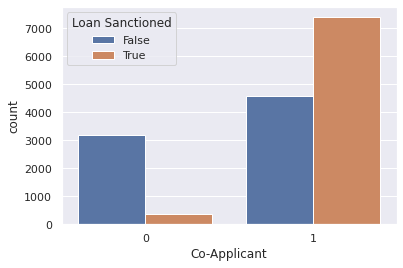

In [71]:
sns.countplot(x=train_clf_sample['Co-Applicant'], hue=train_clf_sample['Loan Sanctioned'])
plt.show()

Co-Applicant has significant impact on target feature. Now we will check out No. of Defautls

In [72]:
train_clf_sample['No. of Defaults'].value_counts()

0    12521
1     3019
Name: No. of Defaults, dtype: int64

In [73]:
default_count = pd.pivot_table(data=train_clf_sample, index='No. of Defaults', columns='Loan Sanctioned',
              values='Customer ID', aggfunc='count', margins=True)

default_count['False_perc'] = (default_count[False] / default_count['All']) * 100
default_count['True_perc'] = 100 - default_count['False_perc']
default_count

Loan Sanctioned  False  True    All  False_perc  True_perc
No. of Defaults                                           
0                 6256  6265  12521    49.96406   50.03594
1                 1514  1505   3019    50.14906   49.85094
All               7770  7770  15540    50.00000   50.00000

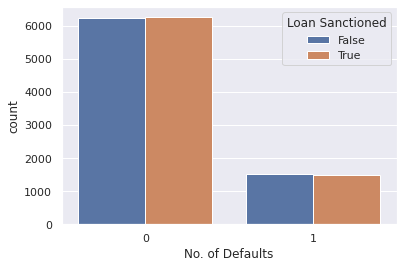

In [74]:
sns.countplot(x='No. of Defaults', hue='Loan Sanctioned', data=train_clf_sample)
plt.show()

No of Defaults does not seem to be very useful feature.
Treating No. of Defautlts and Co-applicant as cateogrical features seemed useful as they only have two category.
Co-Applicant 0 probably mean False
Co-Applicatn 1 probalby mean True

As for No of Defaults it has two categories too. But name does not match with the values. It is probably typing error.

We should have changeed No of Defaults to just Default in dataCleaing part while also changing their data type to object although it making it easier to find relation with doing analysis although it wouldn't have mattered it the model building part since we would have encoded them to numbers anyway

****From the situation above we can see that using a histgram would be useful to figure out new relation with target Loan Sanctioned.****

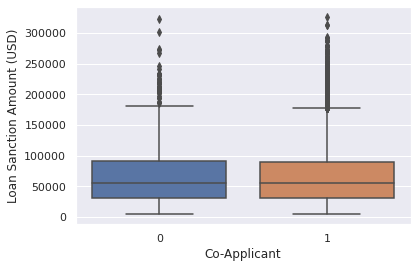

In [75]:
# see if treating these two as  a category has an impact in regression
sns.boxplot(x='Co-Applicant', y='Loan Sanction Amount (USD)', data=train_greater_than_zero)

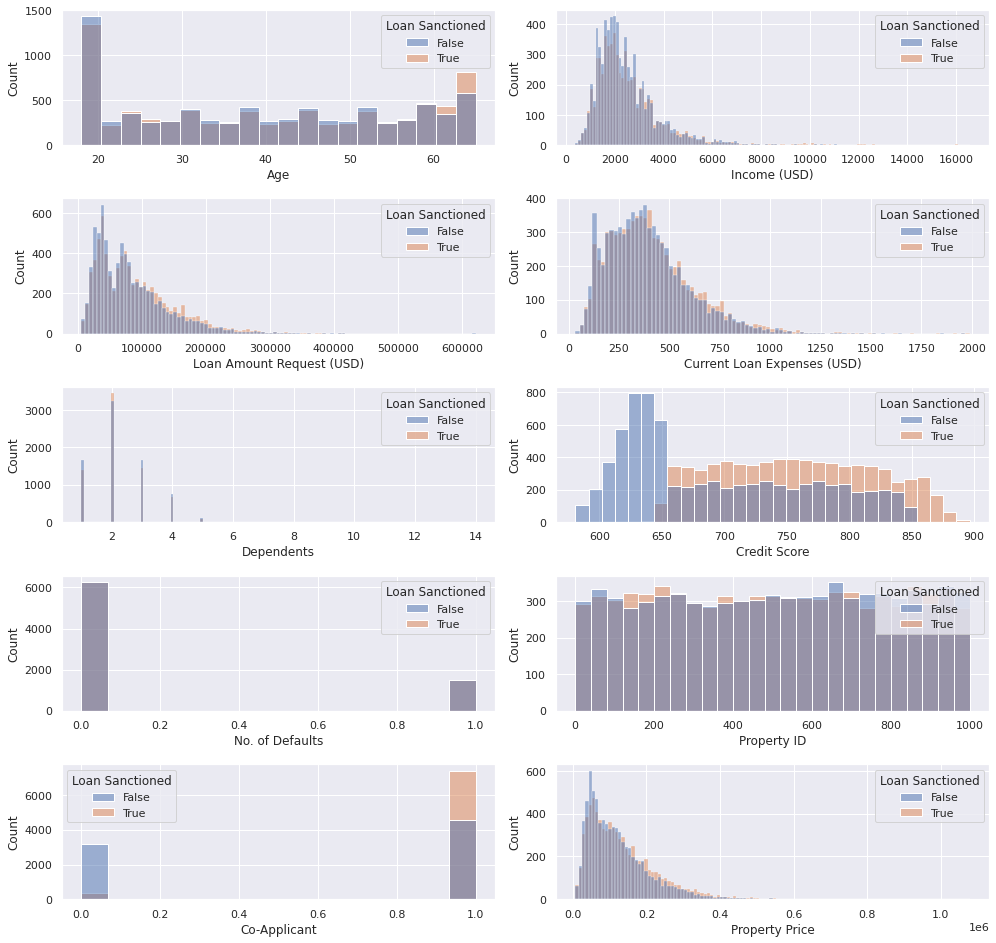

In [76]:
plt.figure(figsize=(14, 18))
for index, col in enumerate(con_feats):
    if index == 1:
        legend = False
    plt.subplot(7, 2, index+1)
    sns.histplot(x=col, hue='Loan Sanctioned', data=train_clf_sample)


plt.tight_layout()

The histograms tell a lot of useful patterns. We will explore them one by one

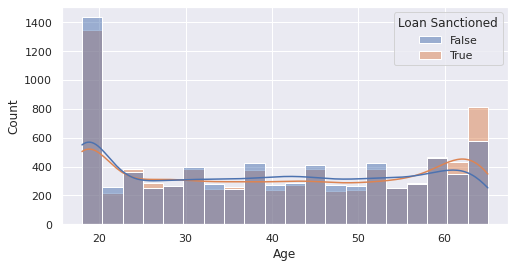

In [77]:
var = 'Age'
plt.figure(figsize=(8, 4))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample, kde=True)
plt.show()

In [78]:
train['Age'].max()

65

In [79]:
var = 'Age'
plt.figure(figsize=(8, 4))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample, bins=[0, 32, 55, 80], legend=False)
plt.show()

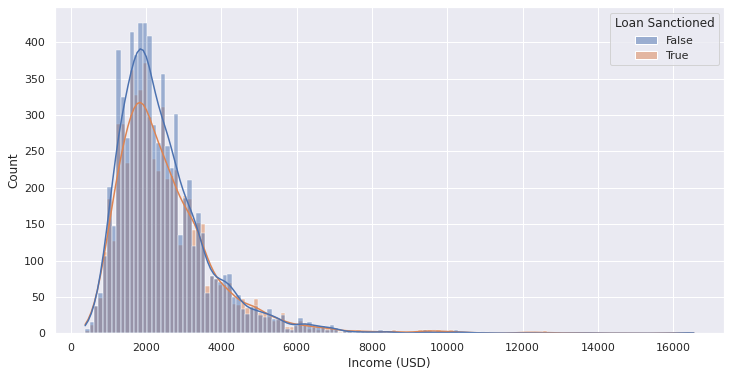

In [80]:
var = 'Income (USD)'
plt.figure(figsize=(12, 6))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample, legend=True, kde=True)
plt.show()

In [81]:
var = 'Income (USD)'
plt.figure(figsize=(8, 4))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample, legend=True, bins=[0, 2800, 17500])
plt.show()

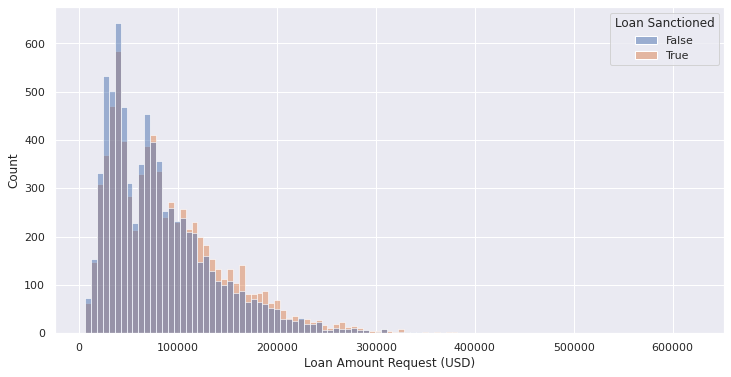

In [82]:
var = 'Loan Amount Request (USD)'
plt.figure(figsize=(12, 6))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample)
plt.show()

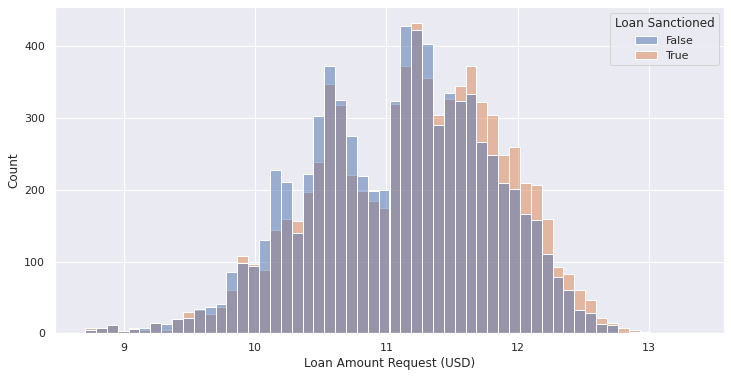

In [83]:
var = np.log(train_clf_sample['Loan Amount Request (USD)'])
plt.figure(figsize=(12, 6))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample)
plt.show()

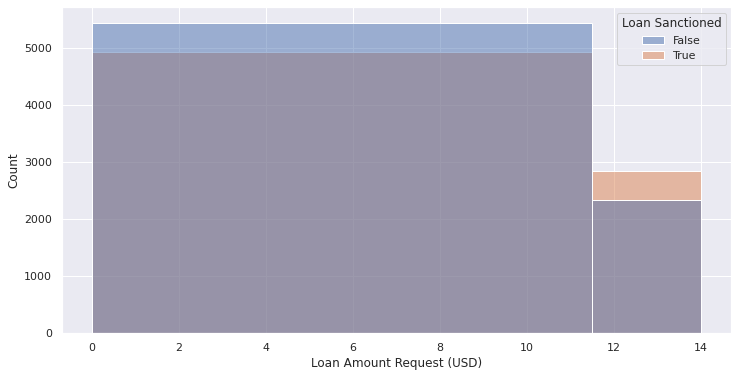

In [84]:
var = np.log(train_clf_sample['Loan Amount Request (USD)'])
plt.figure(figsize=(12, 6))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample, bins=[0, 11.5, 14])
plt.show()

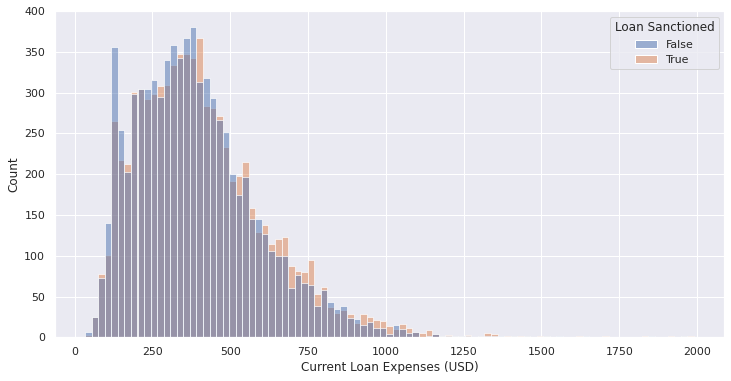

In [85]:
var = 'Current Loan Expenses (USD)'
plt.figure(figsize=(12, 6))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample)
plt.show()

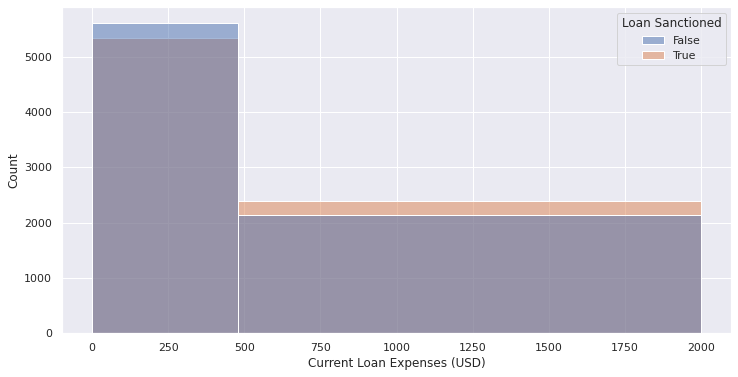

In [86]:
var = 'Current Loan Expenses (USD)'
plt.figure(figsize=(12, 6))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample, bins=[0, 480, 2000])
plt.show()

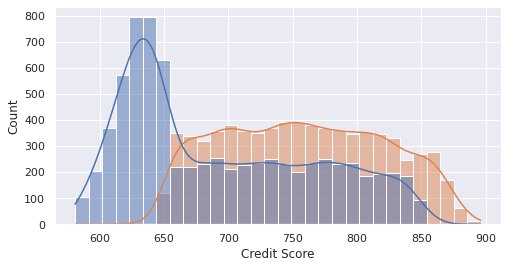

In [87]:
var = 'Credit Score'
plt.figure(figsize=(8, 4))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample, legend=False, kde=True)
plt.show()

In [88]:
var = 'Credit Score'
plt.figure(figsize=(8, 4))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample, legend=False, bins=[0, 650, 850, 1000])
plt.show()

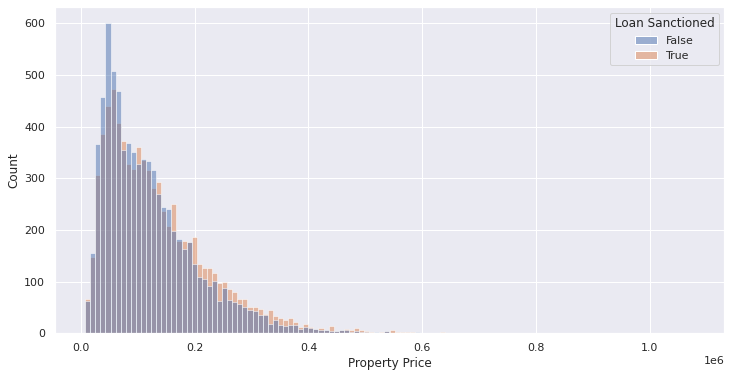

In [89]:
var = 'Property Price'
plt.figure(figsize=(12, 6))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample)

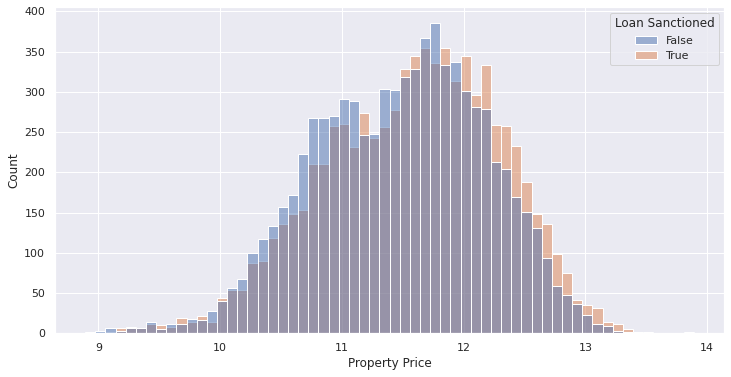

In [90]:
var = np.log(train_clf_sample['Property Price'])
plt.figure(figsize=(12, 6))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample)

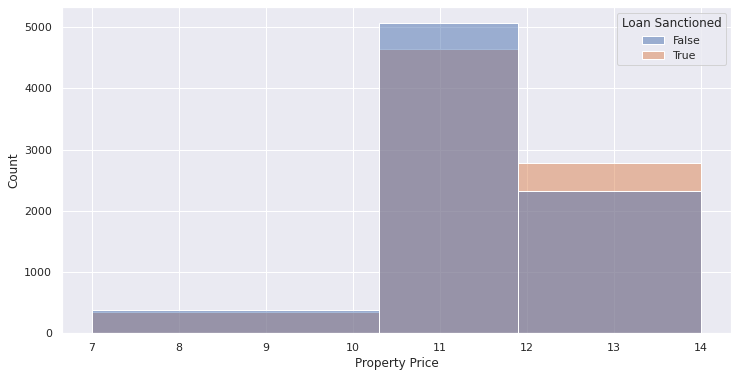

In [91]:
var = np.log(train_clf_sample['Property Price'])
plt.figure(figsize=(12, 6))
sns.histplot(x= var, hue='Loan Sanctioned', data=train_clf_sample, bins=[7, 10.3, 11.9, 14])

****NOTES:****
<br>
* More credits, Co-Applicants has greater chances of having Loan Sanctioned
* Loan Amount Requested, Current Loan Expenses, Property Price, Age impacts the target value when they cross certain threshold
* Those who have co-applicants has more chances of getting loans

****INSIGHTS:****
<br>

* Convert Credit score , Loan Amount Requested, Current Loan Expenses, Property Price,
* Create new feature from Credit Score, Loan Amount Request, Age Income, Current Loan Expenses, Property Price needs to convet to categorical feature as they contain more information that way
  * Credit Score - thresholds - [0, 650, 850, 1000]
  * Property Price - log - thresholds - [8, 10.3, 11.9, 14]
  * Current Loan Expenses (USD) - thresholds - [0, 480, 4000]
  * Loan Amount Request (USD) - log - thresholds - [8, 11.5, 14]
  * Age - thresholds - [0, 32, 55, 80]
  * Income (USD) - [0, 2800, 17500]

Dependents looks unusal spike in getting Loan when it's value is 2. So to tell the model about this information we will create a feature which will tell if Dependents is 2 or not

## Missed Analysis

When we were doing analysis for regression we used Co-Applicant, No of Defaults, Dependents as discrete quantitive data althouh they are ordinal quantitive data. Now will do analysis for regression treating these features as categorical data

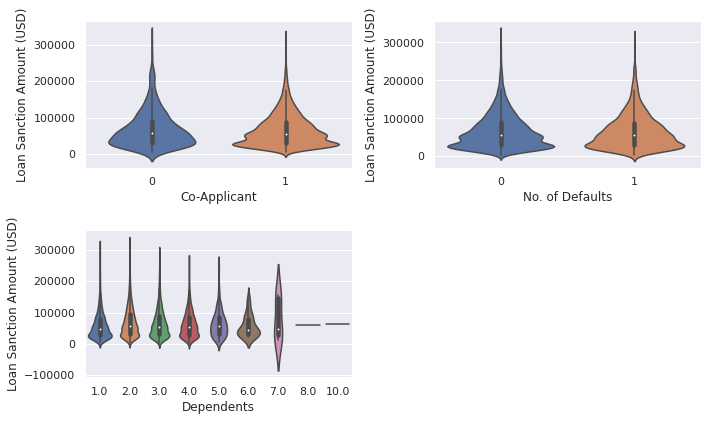

In [92]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
sns.violinplot(x='Co-Applicant', y='Loan Sanction Amount (USD)', data=train_greater_than_zero)

plt.subplot(2, 2, 2)
sns.violinplot(x='No. of Defaults', y='Loan Sanction Amount (USD)', data=train_greater_than_zero)

plt.subplot(2, 2, 3)
sns.violinplot(x='Dependents', y='Loan Sanction Amount (USD)', data=train_greater_than_zero)

plt.tight_layout()

These feature looks pretty significat as they have different distribution and so they will be helpful

# MISSING VALUES


****We will not combine training and testing together to avoid data leakage but before all of this we need to split the training dataset into smaller training and validation dataset****

In [93]:
train.shape

(28652, 23)

In [94]:
# resampling to avoid sampling bias
seed = 10
temp = train.copy()
train_all = temp.sample(frac=1.0, random_state=10)
# splitting into train and validation set
train_set, valid_set = train_test_split(train_all, test_size=0.2, random_state=10)

# checking if the split is correct or not by comparing standard deviation and mean of continous feature a quick and easy way
set_info = ['mean', 'std']

print("Training set: ")
display(train_set.describe().loc[set_info])

print("Validation set: ")
valid_set.describe().loc[set_info]

Training set: 


Age  Income (USD)  Loan Amount Request (USD)  \
mean 39.97849    2534.61497                88792.07359   
std  16.07734    1372.14974                59238.94194   

      Current Loan Expenses (USD)  Dependents  Credit Score  No. of Defaults  \
mean                    408.51455     2.25723     739.67130          0.19484   
std                     213.77541     0.95202      72.13307          0.39609   

      Property ID  Co-Applicant  Property Price  Loan Sanction Amount (USD)  
mean    503.76149       0.85297    133298.57499                 47868.50992  
std     288.51119       0.35414     92427.06723                 47985.38842

Validation set: 


Age  Income (USD)  Loan Amount Request (USD)  \
mean 40.70529    2552.44242                88565.05315   
std  15.99251    1397.63589                59396.26451   

      Current Loan Expenses (USD)  Dependents  Credit Score  No. of Defaults  \
mean                    408.40886     2.24003     741.35571          0.19002   
std                     215.01929     0.95169      72.16011          0.39235   

      Property ID  Co-Applicant  Property Price  Loan Sanction Amount (USD)  
mean    494.49555       0.85029    132474.46984                 48449.19005  
std     286.47628       0.35682     92306.64529                 48423.65944

The split looks okay. We will reset the index so that they can be identified easily when we add the train, valid and test

In [95]:
# train_set.reset_index(drop=True, inplace=True)
# valid_set.reset_index(drop=True, inplace=True)
train_size = train_set.shape[0]
valid_size = valid_set.shape[0]
test_size = test.shape[0]

train_set.index = pd.RangeIndex(start=0, stop=train_size, step=1)
valid_set.index = pd.RangeIndex(start=train_size, stop=valid_size+train_size, step=1)
test.index = pd.RangeIndex(start=train_size+valid_size, stop=valid_size+train_size+test_size, step=1)

In [96]:
# value should be 16663
train_set[train_set["Loan Sanction Amount (USD)"] > 0].shape

(16663, 23)

In [97]:
# missing values percenage in each feature
no_of_rows = train_set.shape[0]
missing_df = train_set.isnull().sum().sort_values(ascending=False).to_frame(name='Missing_count')
missing_df['Missing_percentage'] = np.round((missing_df['Missing_count'] / no_of_rows)*100, 3)
missing_df

Missing_count  Missing_percentage
Type of Employment                    5578            24.33600
Income (USD)                          3418            14.91200
Dependents                            1854             8.08900
Credit Score                          1288             5.61900
Income Stability                      1258             5.48800
Has Active Credit Card                1189             5.18700
Property Location                      268             1.16900
Current Loan Expenses (USD)            126             0.55000
Gender                                  42             0.18300
Customer ID                              0             0.00000
Loan Sanction Amount (USD)               0             0.00000
Property Price                           0             0.00000
Co-Applicant                             0             0.00000
Property Type                            0             0.00000
Property ID                              0             0.00000
Expense Type 2                           0             0.00000
No. of Defaults                          0             0.00000
Expense Type 1                           0             0.00000
Loan Amount Request (USD)                0             0.00000
Location                                 0             0.00000
Profession                               0             0.00000
Age                                      0             0.00000
Loan Sanctioned                          0             0.00000

<b>HEATMAP</b>

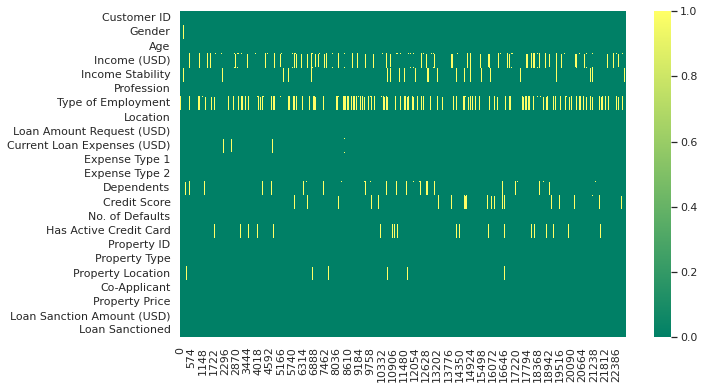

In [98]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_set.isnull().T, cmap='summer')

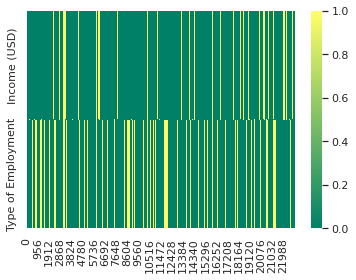

In [99]:
sns.heatmap(train_set.isnull().T.loc[['Income (USD)', "Type of Employment"]], cmap='summer')
plt.show()

Missing values pretty much looks random

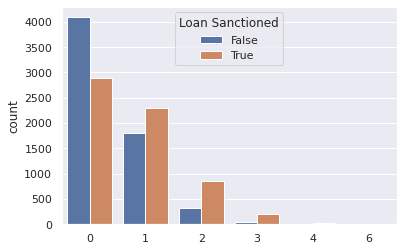

In [100]:
# look into it more
# taking equal amount of true and False to compare easity
false_values = train_set[train_set['Loan Sanctioned'] == False]
true_values = train_set[train_set["Loan Sanctioned"] == True].sample(false_values.shape[0])
temp_df = pd.concat([false_values, true_values])

missing_per_row = temp_df.isnull().sum(axis=1)

sns.countplot(x=missing_per_row, hue=temp_df['Loan Sanctioned'])

<p>Missing values in each feature are independet of each other and does not impact target feature that much. </p>
<p>But Number of missing values in a row shows very intersting relation with Loan Sanctioned which makes sense. So we will create a feature telling us how many nulls are there in each row</p>

In [101]:
# creaing df_main which all store all the through this we can fill in all the data and we do not need to fill in
#  train, valid and test set speartely even though we only use data we got from the train set
df_main = pd.concat([train_set, valid_set, test])
df_main.shape

(48652, 23)

We will start filling in missing values using all known feature and a feature which has null and they are related. We will start with Property ID and Property Location

In [102]:
train_set[train_set['Property ID'] == 92][['Property ID', 'Property Location']].sample(5)

Property ID Property Location
9173            92             Rural
16745           92             Rural
7051            92             Rural
2789            92             Rural
22421           92             Rural

In [103]:
# using group distribution to figure out relation and values to fill in missing values
PPL_gb = train_set.groupby(['Property ID', 'Property Location'])['Customer ID'].size().unstack().fillna(0)
PPL_gb.head(5)

Property Location   Rural  Semi-Urban    Urban
Property ID                                   
1                 0.00000     0.00000 27.00000
2                 0.00000     0.00000 20.00000
3                 0.00000     0.00000 19.00000
4                 0.00000    22.00000  0.00000
5                 0.00000    21.00000  0.00000

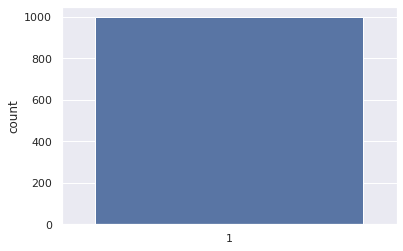

In [104]:
sns.countplot((PPL_gb>0).sum(axis=1))
plt.show()

We can see that for each Property ID the Property Location is always the same. We will fill in missing values in Property Location using Property ID

In [105]:
pl_nulls = df_main["Property Location"].isnull().sum()

null_index = df_main[(df_main['Property Location'].isnull()) & (df_main['Property ID'].isin(PPL_gb.index))].index
df_main.loc[null_index, "Property Location"] = df_main.loc[null_index, 'Property ID'].apply(lambda x: PPL_gb.loc[x].idxmax())

print(f"Number of nulls in Property Location before {pl_nulls}")
print(f"Number of nulls in Property Location after {df_main['Property Location'].isnull().sum()}")


Number of nulls in Property Location before 484
Number of nulls in Property Location after 0


Realation between Income Stability and Profession

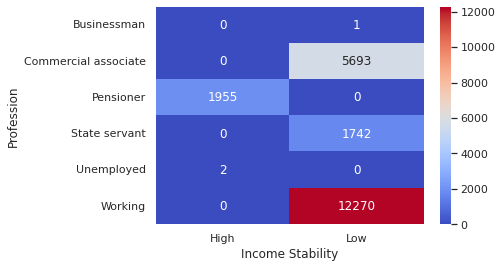

In [106]:
PIS_gb = train_set.groupby(['Profession', 'Income Stability']).size().unstack().fillna(0)
sns.heatmap(PIS_gb, fmt='g', annot=True, cmap='coolwarm')
plt.show()

In [107]:
# using pivot table to generate the same outcome as group by
train_set.pivot_table(values=['Customer ID'], index=['Profession'], columns=['Income Stability'], aggfunc='count').fillna(0)

Customer ID            
Income Stability            High         Low
Profession                                  
Businessman              0.00000     1.00000
Commercial associate     0.00000  5693.00000
Pensioner             1955.00000     0.00000
State servant            0.00000  1742.00000
Unemployed               2.00000     0.00000
Working                  0.00000 12270.00000

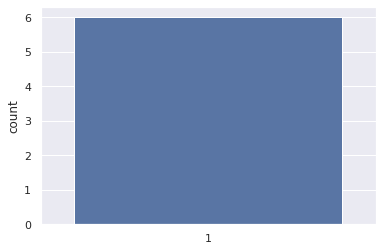

In [108]:
sns.countplot((PIS_gb > 0).sum(axis=1))
plt.show()

For every Profession Income Stability was same indicating that the data is consistent and clean

In [109]:
si_nulls = df_main["Income Stability"].isnull().sum()

null_index = df_main[(df_main['Income Stability'].isnull()) & (df_main['Profession'].isin(PIS_gb.index))].index
df_main.loc[null_index, 'Income Stability'] = df_main.loc[null_index, 'Profession'].apply(lambda x: PIS_gb.loc[x].idxmax())

print(f"Number of nulls in Property Location before {si_nulls}")
print(f"Number of nulls in Property Location after {df_main['Income Stability'].isnull().sum()}")

Number of nulls in Property Location before 2385
Number of nulls in Property Location after 1


In [110]:
df_main[df_main['Income Stability'].isnull()][['Profession', 'Income Stability']]

Profession Income Stability
13667    Student              NaN

The Income Stability of a Student is probably row

In [111]:
si_nulls = df_main["Income Stability"].isnull().sum()

df_main.loc[df_main['Income Stability'].isnull(), "Income Stability"] = "Low"

print(f"Number of nulls in Property Location before {si_nulls}")
print(f"Number of nulls in Property Location after {df_main['Income Stability'].isnull().sum()}")

Number of nulls in Property Location before 1
Number of nulls in Property Location after 0


In [112]:
train_set.shape, valid_set.shape, test.shape

((22921, 23), (5731, 23), (20000, 21))

In [113]:
# a function to quickly update train_set, valid_set, test_set
def get_train_valid_test(df):
  df_train = df_main.loc[df_main['Customer ID'].isin(train_set['Customer ID'])]
  df_valid = df_main.loc[df_main['Customer ID'].isin(valid_set['Customer ID'])]
  df_test = df_main.loc[df_main['Customer ID'].isin(test['Customer ID'])]

  return df_train, df_valid, df_test

# updating train_set, valid_set and test_set
train_set, valid_set, test = get_train_valid_test(df_main)

Type of Employment

In [114]:
# all cateogries in Type of Employment Feature
train_set['Type of Employment'].unique()

array(['Drivers', nan, 'High skill tech staff', 'Laborers', 'Managers',
       'IT staff', 'Accountants', 'Cooking staff', 'Sales staff',
       'Medicine staff', 'Private service staff', 'Core staff',
       'Secretaries', 'Waiters/barmen staff', 'Security staff',
       'Low-skill Laborers', 'Cleaning staff', 'Realty agents',
       'HR staff'], dtype=object)

In [115]:
# all profession in Profession features
train_set['Profession'].unique()

array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Businessman', 'Unemployed', 'Student'], dtype=object)

Profession feature has Pensioner in one it's category but we can see any possible works for them in the Type of Employment feature which looks suspicious. The same is for Unemployed

In [116]:
train_set[train_set['Profession'] == 'Pensioner'][['Profession', 'Type of Employment']].head()

Profession Type of Employment
6   Pensioner                NaN
12  Pensioner                NaN
30  Pensioner                NaN
50  Pensioner                NaN
96  Pensioner                NaN

In [117]:
pensioners = df_main[df_main['Profession'] == 'Pensioner'][['Profession', 'Type of Employment']]
pensioners.shape

(4416, 2)

In [118]:
pensioners.isnull().sum()

Profession               0
Type of Employment    4416
dtype: int64

It seems for all Pensioners there are no Type of Employment. So we will assign them a new category in Type of Employment feature named Retired

In [119]:
df_main.loc[df_main['Profession'] == 'Pensioner', 'Type of Employment'] = "Retired"

In [120]:
# Unemployed also does not have a Type of Employment Assigned to them
df_main[df_main['Profession'] == 'Unemployed'][['Profession', 'Type of Employment']]

Profession Type of Employment
10836  Unemployed                NaN
17333  Unemployed                NaN
34370  Unemployed                NaN
37648  Unemployed                NaN

In [121]:
# for Unemployed we will assign them Notfixed category
df_main.loc[df_main['Profession'] == 'Unemployed', 'Type of Employment'] = "Not Fixed"

In [122]:
missing = df_main['Type of Employment'].isnull().sum()
print(f'Missing values percentage in Type of Employment {round((missing/df_main.shape[0])*100, 2)}%')

Missing values percentage in Type of Employment 14.89%


I could not find any way to fill in null values in Type of Employment features. So we will just rename the nulls as Unknown

In [123]:
df_main['Type of Employment'] = df_main['Type of Employment'].fillna("Unknown")

In [124]:
df_main['Type of Employment'].isnull().sum()

0

In [125]:
train_set, valid_set, test = get_train_valid_test(df_main)

Credit Score

In [126]:
def fill_column(df, target, columns, grp_maps):
  target_series = df[target].copy()
  for grp in grp_maps:
    temp = df.copy()
    for index, col in enumerate(columns):
      temp = temp[temp[col] == grp[0][index]]
      index += 1

    temp_nulls = temp[temp[target].isnull()].index
    if len(temp_nulls) == 0:
      continue

    target_series.loc[temp_nulls] = grp[1]

  return target_series

# def fill_column(df, target, columns, grp_maps):
#   target_series = df[target].copy()
#   for grp in grp_maps:
#     temp = df.copy()
#     for index, col in enumerate(columns):
#       if len(grp[0]) == 1:
#         temp = temp[temp[col] == grp[index]]
#       else:
#         temp = temp[temp[col] == grp[0][index]]

#       index += 1

#     temp_nulls = temp[temp[target].isnull()].index
#     if len(temp_nulls) == 0:
#       continue
#     target_series.loc[temp_nulls] = grp[1]

#   return target_series


In [127]:
train_set.groupby(['Profession', 'Income Stability'])['Credit Score'].median()

Profession            Income Stability
Businessman           Low                779.75000
Commercial associate  Low                742.76000
Pensioner             High               819.35000
State servant         Low                748.07000
Student               Low                637.14000
Unemployed            High               685.29500
Working               Low                723.77000
Name: Credit Score, dtype: float64

In [128]:
cs_nulls = df_main['Credit Score'].isnull().sum()

PTE_gb =  train_set.groupby(['Profession', 'Income Stability'])['Credit Score'].median()
PTE_maps = list(zip(PTE_gb.index, PTE_gb.values))

df_main['Credit Score'] = fill_column(df_main, 'Credit Score', ['Profession', 'Income Stability'], PTE_maps)


print(f"Number of nulls in Credit Score before {cs_nulls}")
print(f"Number of nulls in Credit Score after {df_main['Credit Score'].isnull().sum()}")

Number of nulls in Credit Score before 2317
Number of nulls in Credit Score after 0


Income (USD)

In [129]:
train_set.groupby(['Profession', 'Type of Employment', 'Location'])['Income (USD)'].median().head(10)

Profession            Type of Employment  Location  
Businessman           Core staff          Semi-Urban    2551.67000
                      Managers            Urban        10300.31000
Commercial associate  Accountants         Rural         2423.54000
                                          Semi-Urban    2546.32000
                                          Urban         3831.24500
                      Cleaning staff      Rural         1730.65500
                                          Semi-Urban    1815.68500
                                          Urban         2344.40500
                      Cooking staff       Rural         2096.20000
                                          Semi-Urban    2102.61500
Name: Income (USD), dtype: float64

In [130]:
income_nulls = df_main['Income (USD)'].isnull().sum()

PTEL_gb =  train_set.groupby(['Profession', 'Type of Employment', 'Location'])['Income (USD)'].median()
PTEL_maps = list(zip(PTEL_gb.index, PTEL_gb.values))

df_main['Income (USD)'] = fill_column(df_main, 'Income (USD)', ['Profession', 'Type of Employment', 'Location'], PTEL_maps)


print(f"Number of nulls in Income before {income_nulls}")
print(f"Number of nulls in Income after {df_main['Income (USD)'].isnull().sum()}")

Number of nulls in Income before 5005
Number of nulls in Income after 3


In [131]:
# categories which were not present in training set
df_main[df_main['Income (USD)'].isnull()][['Profession', 'Type of Employment', 'Location']]

Profession    Type of Employment    Location
14318    State servant  Waiters/barmen staff       Urban
17333       Unemployed             Not Fixed  Semi-Urban
22923  Maternity leave               Unknown       Urban

In [132]:
# We will use median to fill in remaining nulls since we can not delete them as they belong to validation and test set
df_main['Income (USD)'] = df_main['Income (USD)'].fillna(train_set['Income (USD)'].median())

In [133]:
print(f"Number of nulls in Income {df_main['Income (USD)'].isnull().sum()}")

Number of nulls in Income 0


In [134]:
train_set, valid_set, test = get_train_valid_test(df_main)

In [135]:
missing_df = train_set.isnull().sum().sort_values(ascending=False).to_frame(name='Missing_count')
missing_df['Missing_percentage'] = np.round((missing_df['Missing_count'] / no_of_rows)*100, 3)
missing_df.head(10)

Missing_count  Missing_percentage
Dependents                            1854             8.08900
Has Active Credit Card                1189             5.18700
Current Loan Expenses (USD)            126             0.55000
Gender                                  42             0.18300
Customer ID                              0             0.00000
Credit Score                             0             0.00000
Loan Sanction Amount (USD)               0             0.00000
Property Price                           0             0.00000
Co-Applicant                             0             0.00000
Property Location                        0             0.00000

Dependents, Has Active Credit Card, Gender, Current Loan Expenses, Co Applicant, Property Price

Since there are no definite way of handling them we will just fill them in with median and mode while labeling the nullsin Has Active Credit Card as Unknown

In [136]:
def fill_null_values(df_main, train, column, mode=False):
  if mode:
    m = train[column].mode()[0]
  else:
    m = train[column].median()

  return df_main[column].fillna(m)


df_main['Dependents'] = fill_null_values(df_main, train_set, 'Dependents')
df_main['Current Loan Expenses (USD)'] = fill_null_values(df_main, train_set, 'Current Loan Expenses (USD)')
df_main['Gender'] = fill_null_values(df_main, train_set, 'Gender', mode=True)

# filling in nulls in Has Active Credit Card with Unknown

df_main['Has Active Credit Card'] = df_main['Has Active Credit Card'].fillna("Unknown")

In [137]:
df_main.isnull().sum().sort_values(ascending=False).head(5)

Loan Sanctioned               20000
Loan Sanction Amount (USD)    20000
Property Price                  168
Co-Applicant                     77
Dependents                        0
dtype: int64

Property Price and Co - Applicants we will fill them in using mode

In [138]:
df_main['Property Price'] = fill_null_values(df_main, train_set, 'Property Price')
df_main['Co-Applicant'] = fill_null_values(df_main, train_set, 'Co-Applicant')

In [139]:
df_main.isnull().sum().sort_values(ascending=False).head(5)

Loan Sanctioned               20000
Loan Sanction Amount (USD)    20000
Dependents                        0
Property Price                    0
Co-Applicant                      0
dtype: int64

In [140]:
train_set, valid_set, test = get_train_valid_test(df_main)

# Feature Engineering

Profession

In [141]:
train_set['Profession'].value_counts()

Working                 12975
Commercial associate     6022
Pensioner                2092
State servant            1827
Businessman                 2
Unemployed                  2
Student                     1
Name: Profession, dtype: int64

In [142]:
df_main['Profession'].value_counts()

Working                 27550
Commercial associate    12841
Pensioner                4416
State servant            3832
Student                     5
Unemployed                  4
Businessman                 2
Maternity leave             2
Name: Profession, dtype: int64

Adding Other Category

In [143]:
var = 'Profession'
# grouping by Profession and counting each profession and if each category has less than 5 observation
# we will return them as other
train_set[var] = train_set.groupby(var)[var].transform(lambda x: x if x.count()> 5 else "Other")
valid_set[var] = valid_set.groupby(var)[var].transform(lambda x: x if x.count()> 5 else "Other")
test[var] = test.groupby(var)[var].transform(lambda x: x if x.count()> 5 else "Other")

In [144]:
train_set['Profession'].value_counts()

Working                 12975
Commercial associate     6022
Pensioner                2092
State servant            1827
Other                       5
Name: Profession, dtype: int64

In [145]:
df_main = pd.concat([train_set, valid_set, test])
df_main.shape

(48652, 23)

Total Expenses

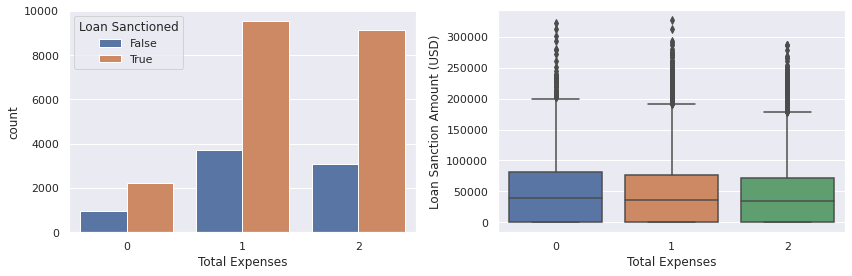

In [146]:
# adding expenses

expense1 = df_main['Expense Type 1'].factorize()[0]
expense2 = df_main['Expense Type 2'].factorize()[0]

total_expenses = pd.Series(expense1 + expense2)
df_main['Total Expenses'] = total_expenses

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='Total Expenses', hue='Loan Sanctioned', data=df_main)
plt.subplot(1, 2, 2)
sns.boxplot(x='Total Expenses', y='Loan Sanction Amount (USD)', data=df_main)

plt.tight_layout()

Now we do feature engineer for classification and regression seprately

Continious to Categorical feature

In [147]:
# a function to make comparison fair and easy
def show_comparison(df, x, hue='Loan Sanctioned'):
  false_clf = df[df['Loan Sanctioned'] == False]
  true_clf = df[df['Loan Sanctioned'] == True].sample(false_clf.shape[0])
  sample_df = pd.concat([false_clf, true_clf])
  sns.countplot(x=x, hue=hue, data=sample_df)

def show_boxplot(df, x, y='Loan Sanction Amount (USD)'):
  df_greater_than_zero = df[df[y] > 0]
  sns.boxplot(x=x, y=y, data=df_greater_than_zero)

In [148]:
# Credit Score
labels = ['0to650', '651to850', '851to1000']
df_main['Credit Score Category'] = pd.cut(df_main['Credit Score'], bins=[0, 650, 850, 1000], labels=labels)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
show_comparison(df_main, 'Credit Score Category')
plt.subplot(1, 2, 2)
show_boxplot(df_main, x='Credit Score Category')

plt.tight_layout()

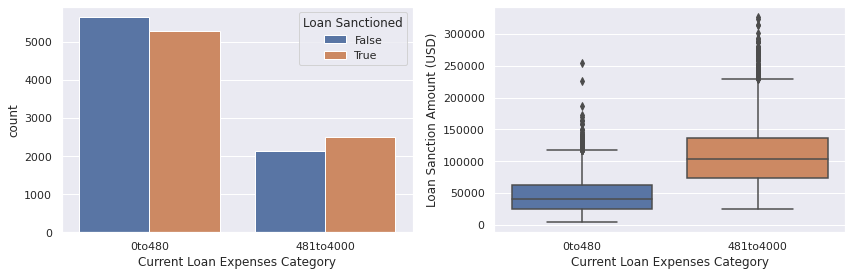

In [149]:
# Current Loan Expenses
labels = ['0to480', '481to4000']
df_main['Current Loan Expenses Category'] = pd.cut(df_main['Current Loan Expenses (USD)'], bins=[0, 480, 4000], labels=labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
show_comparison(df_main, 'Current Loan Expenses Category')
plt.subplot(1, 2, 2)
show_boxplot(df_main, x='Current Loan Expenses Category')

plt.tight_layout()

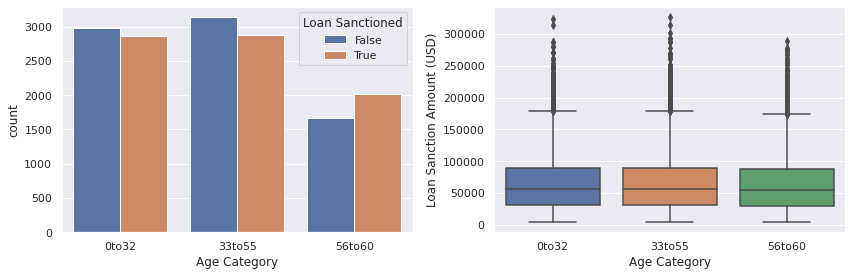

In [150]:
# Age
labels = ['0to32', '33to55', '56to60']
df_main['Age Category'] = pd.cut(df_main['Age'], bins=[0, 32, 55, 80], labels=labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
show_comparison(df_main, 'Age Category')
plt.subplot(1, 2, 2)
show_boxplot(df_main, x='Age Category')

plt.tight_layout()

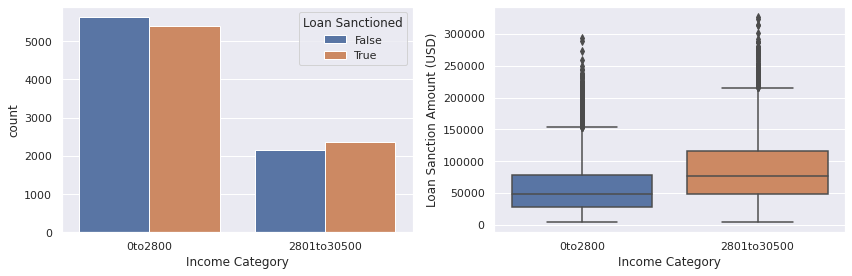

In [151]:
# Income (USD)
labels = ['0to2800', '2801to30500']
df_main['Income Category'] = pd.cut(df_main['Income (USD)'], bins=[0, 2800, 30500], labels=labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
show_comparison(df_main, 'Income Category')
plt.subplot(1, 2, 2)
show_boxplot(df_main, x='Income Category')

plt.tight_layout()

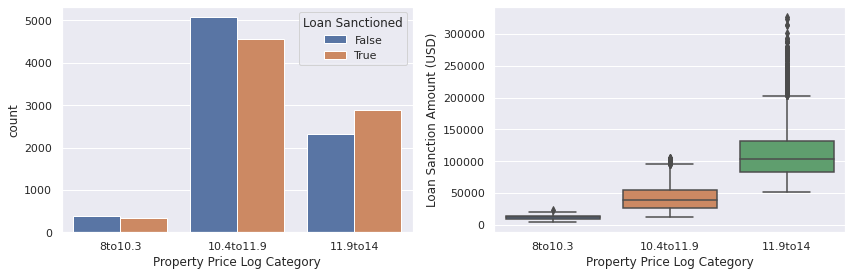

In [152]:
# Property Price - log - thresholds - [8, 10.3, 11.9, 14]
labels = ['8to10.3', '10.4to11.9', '11.9to14']
df_main['Property Price Log Category'] = pd.cut(np.log(df_main['Property Price']), bins=[8, 10.3, 11.9, 14], labels=labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
show_comparison(df_main, 'Property Price Log Category')
plt.subplot(1, 2, 2)
show_boxplot(df_main, x='Property Price Log Category')

plt.tight_layout()

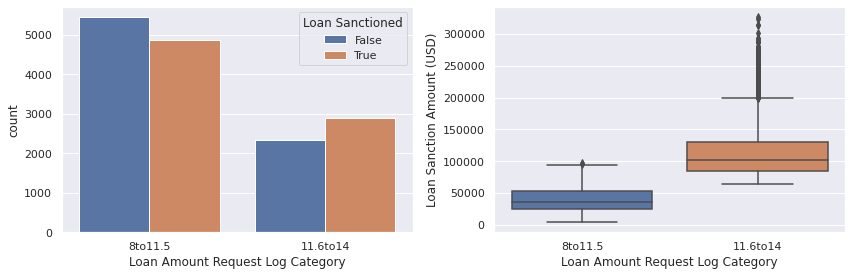

In [153]:
# Loan Amount Request (USD)
labels = ['8to11.5', '11.6to14']
df_main['Loan Amount Request Log Category'] = pd.cut(np.log(df_main['Loan Amount Request (USD)']), bins=[8, 11.5, 14], labels=labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
show_comparison(df_main, 'Loan Amount Request Log Category')
plt.subplot(1, 2, 2)
show_boxplot(df_main, x='Loan Amount Request Log Category')

plt.tight_layout()

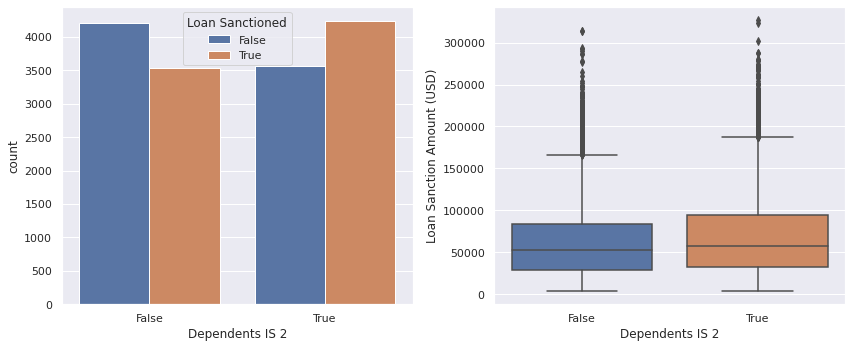

In [154]:
# indicating wheter dependents is 2 or not
def dependents_is_two(x):
  if x == -1:
    return np.nan
  return x == 2


df_main['Dependents'] = df_main['Dependents'].fillna(-1) # replacing null with -1 to make comparison
df_main['Dependents IS 2'] = df_main['Dependents'].map(dependents_is_two)
# replacing -1 with nulls in dependents
df_main['Dependents'] = df_main['Dependents'].replace({-1:np.nan})


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
show_comparison(df_main, 'Dependents IS 2')
plt.subplot(1, 2, 2)
show_boxplot(df_main, x='Dependents IS 2')

plt.tight_layout()

Property ID

Property ID has 999 values which different properties. Even though they are already encoded orderly they are not actually ordianl feature so it does not make sense to Label encode them. We can not one hot encode them either since it would make 999 features just to repesent one value which is not efficient at all. So we will <b>Target Encode</b> this feature

In [155]:
# do it in a latter version

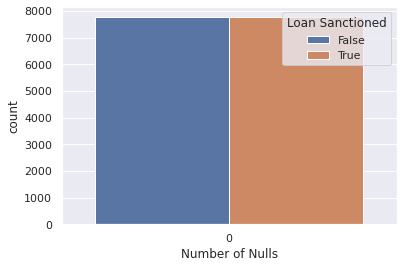

In [156]:
# not sure could be removed later
targets = ['Loan Sanction Amount (USD)', 'Loan Sanctioned']
temp = df_main.copy()
temp["Number of Nulls"] = df_main.drop(columns=targets).shape[1] - df_main.drop(columns=targets).count(axis=1)

show_comparison(temp, 'Number of Nulls')

In [157]:
train_set, valid_set, test = get_train_valid_test(df_main)

# PREPROCESSING
Before doing anything else we need to make sure that data types are okay for all values

In [158]:
df_main.select_dtypes(include=['object', 'category']).dtypes

Customer ID                           object
Gender                                object
Income Stability                      object
Profession                            object
Type of Employment                    object
Location                              object
Expense Type 1                        object
Expense Type 2                        object
Has Active Credit Card                object
Property Type                         object
Property Location                     object
Loan Sanctioned                       object
Credit Score Category               category
Current Loan Expenses Category      category
Age Category                        category
Income Category                     category
Property Price Log Category         category
Loan Amount Request Log Category    category
dtype: object

In [159]:
category_cols = ['Credit Score Category', 'Current Loan Expenses Category',
                  'Age Category', 'Income Category', 'Property Price Log Category', 'Loan Amount Request Log Category']

df_main[category_cols] = df_main[category_cols].astype('object')

In [160]:
df_main.select_dtypes(include=['int', 'float']).dtypes

Age                              int64
Income (USD)                   float64
Loan Amount Request (USD)      float64
Current Loan Expenses (USD)    float64
Dependents                     float64
Credit Score                   float64
No. of Defaults                  int64
Property ID                      int64
Co-Applicant                   float64
Property Price                 float64
Loan Sanction Amount (USD)     float64
Total Expenses                   int64
dtype: object

In [161]:
df_main['Co-Applicant'] = df_main['Co-Applicant'].astype('int')
df_main['Dependents IS 2'] = df_main['Dependents IS 2'].astype('int')
df_main['Dependents'] = df_main['Dependents'].astype('int')

****Encoding****

<p>We need to encode features Income Stabilty, Location, Property Location, Has Active Credit Card orderly since they are ordinal data</p>

In [162]:
df_main.shape

(48652, 31)

In [163]:
print(f"Income stability: {df_main['Income Stability'].unique()}")
print(f"Income Location: {df_main['Location'].unique()}")
print(f"Income Property: {df_main['Property Location'].unique()}")
print(f"Income Has Active Credit Card: {df_main['Has Active Credit Card'].unique()}")

Income stability: ['Low' 'High']
Income Location: ['Semi-Urban' 'Urban' 'Rural']
Income Property: ['Urban' 'Semi-Urban' 'Rural']
Income Has Active Credit Card: ['Unpossessed' 'Active' 'Inactive' 'Unknown']


In [164]:
# try to see how to do the same with OrdinalEncoding
df_main['Income Stability Ordered'] = df_main['Income Stability'].replace({'Low': 1, 'High': 2})
df_main['Location Ordered'] = df_main['Location'].replace({'Rural': 1, 'Semi-Urban': 2, 'Urban':3})
df_main['Property Location Ordered'] = df_main['Property Location'].replace({'Rural': 1, 'Semi-Urban': 2, 'Urban':3})
df_main['Has Active Credit Card Ordered'] = df_main['Has Active Credit Card'].replace({'Unknown': 0, 'Unpossessed': 1, 'Inactive': 2, "Active": 3})

In [165]:
print(f"Income stability Ordered: {df_main['Income Stability Ordered'].unique()}")
print(f"Income Location Ordered: {df_main['Location Ordered'].unique()}")
print(f"Income Property Ordered: {df_main['Property Location Ordered'].unique()}")
print(f"Income Has Active Credit Card Ordered: {df_main['Has Active Credit Card Ordered'].unique()}")

Income stability Ordered: [1 2]
Income Location Ordered: [2 3 1]
Income Property Ordered: [3 2 1]
Income Has Active Credit Card Ordered: [1 3 2 0]


****Log/Power Transformation****

In [166]:
col_to_log = ['Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Property Price']
plt.figure(figsize=(15, 10))

for index, col in enumerate(col_to_log):
  plt.subplot(4, 2, 2*index+1)
  sns.histplot(x=df_main[col], kde=True)
  plt.title(f'Histogram Without Log')

  plt.subplot(4, 2, 2*index+2)
  sns.histplot(x=np.log(df_main[col]), kde=True)
  plt.title(f'Histogram With Log')

plt.tight_layout()

In [167]:
# log transforming features
for col in col_to_log:
    df_main[col] = np.log(df_main[col])

In [168]:
train_set, valid_set, test_set = get_train_valid_test(df_main)

In [169]:
# we need to power transform target feature Loan Sanction Amount too
train_greater_than_zero = train_set[train_set['Loan Sanction Amount (USD)'] > 0]
valid_greater_than_zero = valid_set[valid_set['Loan Sanction Amount (USD)'] > 0]

target_train = train_greater_than_zero.loc[:, ['Loan Sanction Amount (USD)']]
target_valid = valid_greater_than_zero.loc[:, ['Loan Sanction Amount (USD)']]

target_reg_train_index = target_train.index
target_reg_valid_index = target_valid.index

power_transform = PowerTransformer(method='yeo-johnson')
train_set.loc[target_reg_train_index, "Loan Sanction Amount (USD)"] = power_transform.fit_transform(target_train).flatten()
valid_set.loc[target_reg_valid_index, "Loan Sanction Amount (USD)"] = power_transform.transform(target_valid).flatten()

In [170]:
# 3-12-2022 8:16 PM
target_reg_train_index.shape

(16663,)

In [171]:
# updating df main
df_main = pd.concat([train_set, valid_set, test_set])

****Scaling****

In [172]:
columns = df_main.select_dtypes(include=['object', 'category']).columns

for col in columns:
  if col == "Customer ID" or col == 'Loan Sanctioned':
      continue
  print(f"For df_main {col}: {df_main[col].astype('object').unique()}")

For df_main Gender: ['F' 'M']
For df_main Income Stability: ['Low' 'High']
For df_main Profession: ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Other']
For df_main Type of Employment: ['Drivers' 'Unknown' 'High skill tech staff' 'Laborers' 'Retired'
 'Managers' 'IT staff' 'Accountants' 'Cooking staff' 'Sales staff'
 'Medicine staff' 'Private service staff' 'Core staff' 'Secretaries'
 'Waiters/barmen staff' 'Security staff' 'Low-skill Laborers'
 'Cleaning staff' 'Realty agents' 'HR staff' 'Not Fixed']
For df_main Location: ['Semi-Urban' 'Urban' 'Rural']
For df_main Expense Type 1: ['Y' 'N']
For df_main Expense Type 2: ['N' 'Y']
For df_main Has Active Credit Card: ['Unpossessed' 'Active' 'Inactive' 'Unknown']
For df_main Property Type: ['property_type_2' 'property_type_3' 'Property_type_4' 'property_type_1']
For df_main Property Location: ['Urban' 'Semi-Urban' 'Rural']
For df_main Credit Score Category: ['651to850' '0to650' '851to1000']
For df_main Current Loan Expenses

In [173]:
columns = df_main.select_dtypes(include=['float', 'int']).columns

# for train
for col in columns:
    max = df_main[col].max()
    min = df_main[col].min()
    print(f"For df main feature {col} range is [{min} to {max}]")

For df main feature Age range is [18 to 65]
For df main feature Income (USD) range is [5.909684915187837 to 10.323107999432471]
For df main feature Loan Amount Request (USD) range is [8.707522599611721 to 13.339887682283951]
For df main feature Current Loan Expenses (USD) range is [3.5192766697277564 to 8.103485203929633]
For df main feature Dependents range is [1 to 14]
For df main feature Credit Score range is [580.04 to 896.26]
For df main feature No. of Defaults range is [0 to 1]
For df main feature Property ID range is [1 to 999]
For df main feature Co-Applicant range is [0 to 1]
For df main feature Property Price range is [8.890954331392207 to 13.890587167266096]
For df main feature Loan Sanction Amount (USD) range is [-2.872920382460355 to 3.0381176860550925]
For df main feature Total Expenses range is [0 to 2]
For df main feature Dependents IS 2 range is [0 to 1]
For df main feature Income Stability Ordered range is [1 to 2]
For df main feature Location Ordered range is [1 to 3

In [174]:
# train_set, valid_set, test_set = get_train_valid_test(df_main)

In [175]:
# test_set = test_set.drop(columns=['Loan Sanction Amount (USD)', 'Loan Sanctioned'])

In [176]:
# train_set.drop(columns=['Customer ID'], inplace=True)
# valid_set.drop(columns=['Customer ID'], inplace=True)
# test_set.drop(columns=['Customer ID'], inplace=True)

# FEATURE SELECTION

Previously during analyzing our dataset we used visualization to find the features with most predictive power but now we will use statstical method to filter the most important features

In [177]:
train_set, valid_set, test_set = get_train_valid_test(df_main)

In [178]:
train_set.shape

(22921, 35)

## Regression

We will use the methods below
* input numerical and output numerical
  * mutual info regression
  * correlation coefficient
* input categorical and output numerical
  * Anova


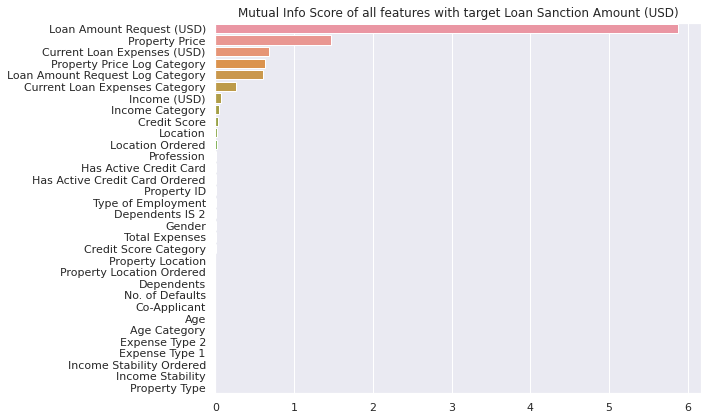

In [179]:
# for numerical inputs
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y, discrete_features):
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
  mi_scores = pd.Series(mi_scores, name='MI scores', index=X.columns)
  return mi_scores.sort_values(ascending=False)

# we can not use "Loan Sanction Amount (USD)" > 0 because we have previously johnsohn transformed this feature which created many values with 0
X = train_set.loc[target_reg_train_index].drop(columns=['Loan Sanction Amount (USD)', 'Loan Sanctioned', 'Customer ID'])
y = train_set.loc[target_reg_train_index]["Loan Sanction Amount (USD)"]

for col in X.select_dtypes('object'):
  X[col], _ = X[col].factorize()

discrete_features = X.dtypes == int


mi_scores = make_mi_scores(X, y, discrete_features=discrete_features)


fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax = sns.barplot(y=mi_scores.index, x=mi_scores.values, orient='h')
# for i in ax.containers[0]:
#     ax.bar_label(i)

ax.set_title("Mutual Info Score of all features with target Loan Sanction Amount (USD)")
plt.tight_layout()

HEATMAP

we will spearman method which uses rank sytem thorught which we can also detect non linear relationship while pearson method can only pickup linear relation

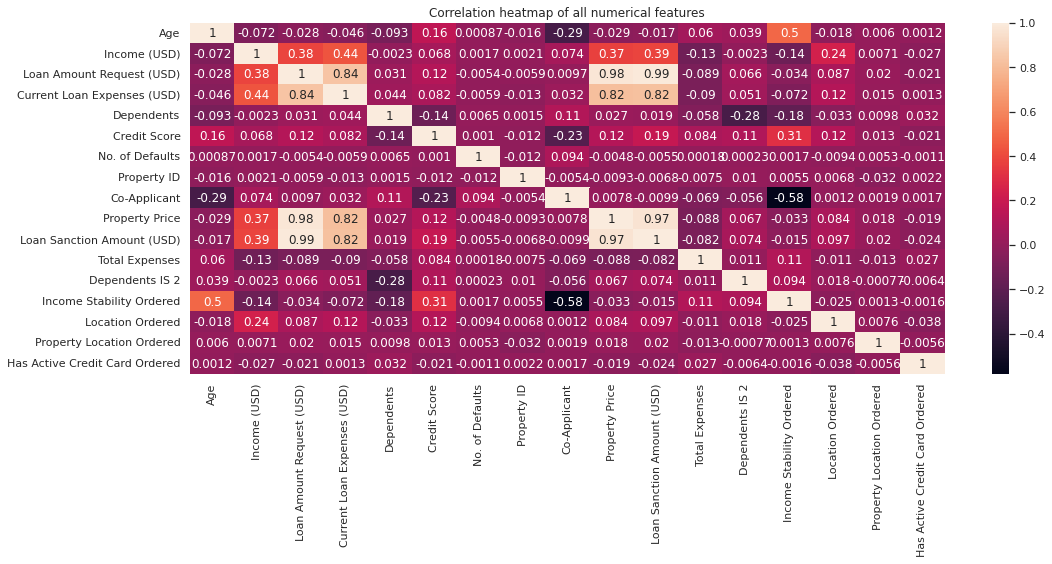

In [180]:
plt.figure(figsize=(16, 8))
corr_features = train_set.loc[target_reg_train_index].corr('pearson')
sns.heatmap(corr_features, annot=True)
plt.title("Correlation heatmap of all numerical features")
plt.tight_layout()

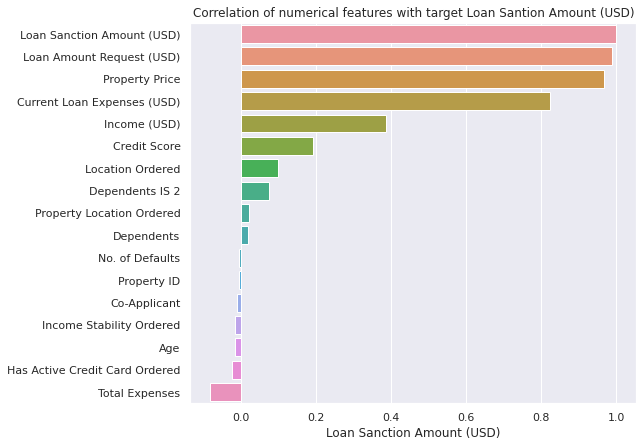

In [181]:
plt.figure(figsize=(8, 7))
corr_target = corr_features['Loan Sanction Amount (USD)'].sort_values(ascending=False)
sns.barplot(x=corr_target, y=corr_target.index)
plt.title("Correlation of numerical features with target Loan Santion Amount (USD)")
plt.show()

In [182]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

train_greater_than_zero = train_set.loc[target_reg_train_index].select_dtypes(include=['float', 'int'])
X, y = train_greater_than_zero.drop(columns='Loan Sanction Amount (USD)'), train_greater_than_zero['Loan Sanction Amount (USD)']

fs = SelectKBest(score_func=f_regression, k=10)
X_selected = fs.fit_transform(X, y)

We can see that there a lot of features such as  No. of Defaults, Age, Property Type, Co-Applicant, Age Category, Expense Type 2, Expense Type1, Income Stability has very low mi scores meaning having these features as predictor does not reduces uncertanity in target Loan Sanction Amount.
Moreover a lot of features has multicolinearity problem with correaltion greater than 0.7

Loan Amount Request - Property Price<br>
Loan Amount Request - Current Loan Expenses<br>
Current Loan Expenses - Property Price<br>

We will give precendence to Loan Amount Request as it has more correlation with target value


Noramlly we would have removed any colinearity but since we will use regularization to build models we will keep during. We will also not remove the last category during one hot encoding as they are good practices for Regularization

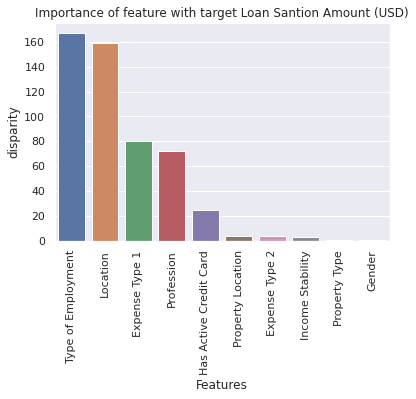

In [183]:
def anova(frame):
    anv = pd.DataFrame()
    anv['Features'] = cat_feats
    pvals = []
    for feats in anv['Features']:
        samples = []
        for category in frame[feats].unique():
            s = frame[frame[feats] == category]['Loan Sanction Amount (USD)'].values
            samples.append(s)

        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)

    anv['Pvals'] = pvals

    return anv.sort_values(by='Pvals')

a = anova(train_set.loc[target_reg_train_index])
a['disparity'] = np.log(1./a['Pvals'].values)
sns.barplot(data=a, x='Features', y='disparity')
plt.title("Importance of feature with target Loan Santion Amount (USD)")
plt.xticks(rotation=90)
plt.show()

## Classification

* Categorical & Nuemrical Input and Categorical Output
  * Mututal Info Regression
* Categorical Input & Categorical Output
  * Chi Squared Test

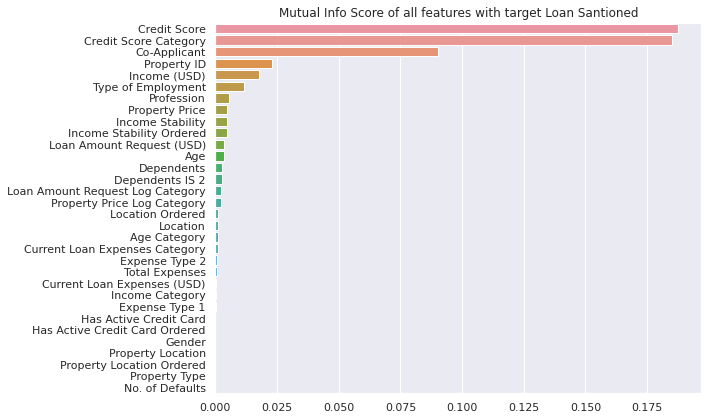

In [184]:
# for all features
def make_mi_scores(X, y, discrete_features):
  mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
  mi_scores = pd.Series(mi_scores, name='MI scores', index=X.columns)
  return mi_scores.sort_values(ascending=False)


X = train_set.drop(columns=['Loan Sanctioned', 'Customer ID', 'Loan Sanction Amount (USD)'])
y = train_set['Loan Sanctioned'].astype('int')

for col in X.select_dtypes('object'):
  X[col], _ = X[col].factorize()

discrete_features = X.dtypes == int


mi_scores = make_mi_scores(X, y, discrete_features=discrete_features)


plt.figure(figsize=(10, 6))
sns.barplot(y=mi_scores.index, x=mi_scores.values, orient='h')
plt.title("Mutual Info Score of all features with target Loan Santioned")
plt.tight_layout()

In [185]:
# for categorical features only
X = train_set.drop(columns=['Loan Sanctioned', 'Customer ID', 'Loan Sanction Amount (USD)']).select_dtypes(include=['object'])
y = train_set['Loan Sanctioned'].astype('int')


# we need to encode the features first
for col in X.columns:
  label_encoder = LabelEncoder()
  X[col] = label_encoder.fit_transform(X.loc[:, [col]])


# calculation chi scores and plotting them
chi_scores = chi2(X,y)

chi_stats = pd.Series(chi_scores[0], index=X.columns)
chi_stats.sort_values(ascending = False , inplace = True)

p_values = pd.Series(chi_scores[1], index=X.columns)
p_values.sort_values(ascending = False , inplace = True)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(y=chi_stats.index, x=chi_stats, orient='h')
plt.title('Chi stats Values signifying importance of the feature')

plt.subplot(1, 2, 2)
sns.barplot(y=p_values.index, x=p_values, orient='h')
plt.title('P values signifying Less important feature for target Loan Santioned')

plt.tight_layout()

Chi Values where higher values mean more impact with target

P values where higher values mean this variables is independent of the repsone and can not be considered for model training

****Normally we would have selected a method select the best features with SelectKBest but since we do not have a lot of feature and most of the feature selection method gives us the same result we will try modeling with all features first****

# MODEL BUILDING

In [186]:
# we will one hot encode Type of Employment first as we want to specifically drop "Unknown" Category only
emp_type_dummies = pd.get_dummies(df_main['Type of Employment']).drop(columns=['Unknown'])
df_main = pd.concat([df_main, emp_type_dummies], axis=1)
df_main.drop(columns='Type of Employment', inplace=True)

train_set, valid_set, test_set = get_train_valid_test(df_main)

In [187]:
# 21, 54
train_set.shape

(22921, 54)

> Regression Baseline

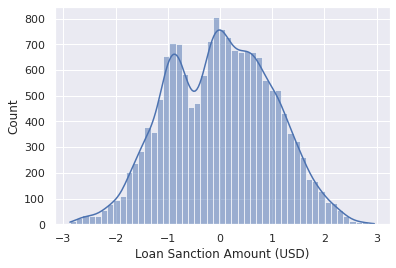

In [188]:
sns.histplot(train_set.loc[target_reg_train_index]['Loan Sanction Amount (USD)'],  kde=True)

In [189]:
pred_size = valid_set.loc[target_reg_valid_index].shape[0]
pred_true = valid_set.loc[target_reg_valid_index]['Loan Sanction Amount (USD)']

predicted_median = pd.Series(np.zeros(pred_size))
median = train_set.loc[target_reg_train_index]['Loan Sanction Amount (USD)'].median()
predicted_median.loc[:] = median

mae = mean_squared_error(pred_true, predicted_median)
print(f"Root Mean Squared Error is {np.sqrt(mae)} while assuming all predicted values are median")

Root Mean Squared Error is 0.9907361623590273 while assuming all predicted values are median


## Classification Model Selection



> Classification Baseline

For a model to be accepted it has score better than the baseline to be considered succesfful

In [190]:
train_set['Loan Sanctioned'].value_counts()

True     16663
False     6258
Name: Loan Sanctioned, dtype: int64

In [191]:
# classification where all predicted values are True
predicted_mode = pd.Series(np.ones(valid_set.shape[0]))

accuracy = accuracy_score(valid_set['Loan Sanctioned'].astype("int"), predicted_mode)
print(f"Accuracy of {round(accuracy*100, 3)}% while assuming all predicted values are mode 1")

Accuracy of 73.617% while assuming all predicted values are mode 1


In [199]:
def get_train_valid_cls(train_set, valid_set, smote_oversample=False, round=False):

  X_train_cls = train_set.drop(columns=['Loan Sanctioned', 'Customer ID'])
  X_valid_cls = valid_set.drop(columns=['Loan Sanctioned', "Customer ID"])

  y_train_cls = train_set['Loan Sanctioned'].astype("int")
  y_valid_cls = valid_set['Loan Sanctioned'].astype('int')

  # removing Loan Santioned Amount to prevent Data Leakage
  X_train_cls.drop(columns=['Loan Sanction Amount (USD)'], inplace=True)
  X_valid_cls.drop(columns=['Loan Sanction Amount (USD)'], inplace=True)


  categorical_cols = X_train_cls.select_dtypes(include=['object']).columns
  numerical_cols = X_train_cls.select_dtypes(include=['int', 'float']).columns

  categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))])
  numerical_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

  ct_cls = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)],
        remainder='passthrough')

  X_train_cls = ct_cls.fit_transform(X_train_cls)
  X_valid_cls = ct_cls.transform(X_valid_cls)


  if round:
    # rounding the values tot 4 decimals so that they take less time to train
    X_train_cls = np.round(X_train_cls, decimals=4)
    X_valid_cls = np.round(X_valid_cls, decimals=4)

  if smote_oversample:
    sm = SMOTE(sampling_strategy='minority')
    X_train_cls, y_train_cls = sm.fit_resample(X_train_cls, y_train_cls)

  return X_train_cls, X_valid_cls, y_train_cls, y_valid_cls

In [ ]:
# cols = ['Credit Score', 'Property Price', "Current Loan Expenses (USD)", 'Loan Amount Request (USD)', 'Age', 'Income (USD)']

In [200]:
X_train_cls, X_valid_cls, y_train_cls, y_valid_cls = get_train_valid_cls(train_set, valid_set, round=True)
X_train_cls.shape, X_valid_cls.shape
# 63

((22921, 63), (5731, 63))

The next three cells ****Breif Explanation of models**** and ****Define Models**** are both taken from <a href='https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide/notebook'>Spaceship Titanic: A complete guide</a> by <a href='https://www.kaggle.com/samuelcortinhas'>Samuel Cortinhas</a>.
Infact a lot of process and steps including template was inspired from the notebook specified above specially how to handle missing values

> Breif Explanation of models

To briefly mention the algorithms we will use,

<b>Logistic Regression:</b> Unlike linear regression which uses Least Squares, this model uses Maximum Likelihood Estimation to fit a sigmoid-curve on the target variable distribution. The sigmoid/logistic curve is commonly used when the data is questions had binary output.

<b>K-Nearest Neighbors (KNN):</b> KNN works by selecting the majority class of the k-nearest neighbours, where the metric used is usually Euclidean distance. It is a simple and effective algorithm but can be sensitive by many factors, e.g. the value of k, the preprocessing done to the data and the metric used.

<b>Support Vector Machine (SVM):</b> SVM finds the optimal hyperplane that seperates the data in the feature space. Predictions are made by looking at which side of the hyperplane the test point lies on. Ordinary SVM assumes the data is linearly separable, which is not always the case. A kernel trick can be used when this assumption fails to transform the data into a higher dimensional space where it is linearly seperable. SVM is a popular algorithm because it is computationally effecient and produces very good results.

<b>Random Forest (RF):</b> RF is a reliable ensemble of decision trees, which can be used for regression or classification problems. Here, the individual trees are built via bagging (i.e. aggregation of bootstraps which are nothing but multiple train datasets created via sampling with replacement) and split using fewer features. The resulting diverse forest of uncorrelated trees exhibits reduced variance; therefore, is more robust towards change in data and carries its prediction accuracy to new data. It works well with both continuous & categorical data.

<b>Extreme Gradient Boosting (XGBoost):</b> XGBoost is similar to RF in that it is made up of an ensemble of decision-trees. The difference arises in how those trees as derived; XGboost uses extreme gradient boosting when optimising its objective function. It often produces the best results but is relatively slow compared to other gradient boosting algorithms.

<b>Light Gradient Boosting Machine (LGBM):</b> LGBM works essentially the same as XGBoost but with a lighter boosting technique. It usually produces similar results to XGBoost but is significantly faster.

<b>Categorical Boosting (CatBoost):</b> CatBoost is an open source algorithm based on gradient boosted decision trees. It supports numerical, categorical and text features. It works well with heterogeneous data and even relatively small data. Informally, it tries to take the best of both worlds from XGBoost and LGBM.

<b>Naive Bayes (NB):</b> Naive Bayes learns how to classify samples by using Bayes' Theorem. It uses prior information to 'update' the probability of an event by incoorporateing this information according to Bayes' law. The algorithm is quite fast but a downside is that it assumes the input features are independent, which is not always the case.

We will train these models and evaluate them on the validation set to then choose which ones to carry through to the next stage (cross validation).

> Define Models

In [207]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    # "SVC" : SVC(random_state=0), we will not use SVC as it is taking too long to train for some reason
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
    # "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}


grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

In [241]:
def get_cls_model_scores(X_train_cls, X_valid_cls, y_train_cls, y_valid_cls, classifiers,  grid, n_iter=3, report=True):
  clf_best_params = classifiers.copy()
  size = len(classifiers)
  index = 0
  validation_scores = pd.DataFrame({'classifiers': classifiers.keys(), "training_score": np.zeros(size), "validation_score": np.zeros(size), 
                                    "training_time": np.zeros(size)})


  for key, classifier in classifiers.items():
    start= time.time()

    rand_cv = RandomizedSearchCV(classifier, grid[key], n_jobs=-1, cv=None, n_iter=3)
    rand_cv.fit(X_train_cls, y_train_cls)

    validation_scores.loc[index, "training_score"] = rand_cv.score(X_train_cls, y_train_cls)
    validation_scores.loc[index, 'validation_score'] = rand_cv.score(X_valid_cls, y_valid_cls)
    clf_best_params[key] = rand_cv.best_params_

    end = time.time()

    time_taken = (end - start)/60
    validation_scores.loc[index, "training_time"] = time_taken

    print('Model:', key)
    if report:
      print(classification_report(y_valid_cls, rand_cv.predict(X_valid_cls)))
      print('')

    index += 1

  return validation_scores

In [245]:
validation_scores = get_cls_model_scores(X_train_cls, X_valid_cls, y_train_cls, y_valid_cls, classifiers, grid, n_iter=3, report=True)
validation_scores
# add a photo

Model: LogisticRegression
              precision    recall  f1-score   support

           0       1.00      0.69      0.81      1512
           1       0.90      1.00      0.95      4219

    accuracy                           0.92      5731
   macro avg       0.95      0.84      0.88      5731
weighted avg       0.93      0.92      0.91      5731


Model: KNN
              precision    recall  f1-score   support

           0       0.95      0.41      0.57      1512
           1       0.82      0.99      0.90      4219

    accuracy                           0.84      5731
   macro avg       0.89      0.70      0.74      5731
weighted avg       0.86      0.84      0.81      5731


Model: RandomForest
              precision    recall  f1-score   support

           0       1.00      0.68      0.81      1512
           1       0.90      1.00      0.95      4219

    accuracy                           0.92      5731
   macro avg       0.95      0.84      0.88      5731
weighted avg   

classifiers  training_score  validation_score  training_time
0  LogisticRegression         0.91366           0.91729        0.09300
1                 KNN         0.85446           0.83807        1.53530
2        RandomForest         0.91615           0.91624        0.79059
3             XGBoost         0.91671           0.91659        2.13099
4                LGBM         0.91567           0.91799        0.09981
5          NaiveBayes         0.42516           0.42523        0.00912

Other than NaiveBayes all of the models pass the vaseline score however because of class imbalance the values of class 0 have a very poor recall and F1 score. Surprisingly most of the models values are also the same other than KNN

What I have observed from the result is that it all the time recall and f1 score is pretty low of class 1 as it has very few instance.

Now we have two choice one is the use undersampling and other is oversampling we will use oversampling. Because if you remember correctly we have some input features which were highly unbalanced. So reducing the category 1 class may give us less score.

In [243]:
class_false = train_set[train_set["Loan Sanctioned"] == False]
class_true = train_set[train_set["Loan Sanctioned"] == True].sample(class_false.shape[0], random_state=0)

train_set_undersampled = pd.concat([class_true, class_false])

X_train_cls_under, X_valid_cls, y_train_cls_under, y_valid_cls = get_train_valid_cls(train_set_undersampled, valid_set, round=True)

In [244]:
validation_scores = get_cls_model_scores(X_train_cls_under, X_valid_cls, y_train_cls_under,
                                         y_valid_cls, classifiers, grid, n_iter=1, report=True)
validation_scores

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1512
           1       0.90      0.97      0.93      4219

    accuracy                           0.90      5731
   macro avg       0.89      0.84      0.86      5731
weighted avg       0.90      0.90      0.90      5731


Model: KNN
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      1512
           1       0.87      0.86      0.87      4219

    accuracy                           0.81      5731
   macro avg       0.75      0.76      0.75      5731
weighted avg       0.81      0.81      0.81      5731


Model: RandomForest
              precision    recall  f1-score   support

           0       1.00      0.69      0.81      1512
           1       0.90      1.00      0.95      4219

    accuracy                           0.92      5731
   macro avg       0.95      0.84      0.88      5731
weighted avg   

classifiers  training_score  validation_score  training_time
0  LogisticRegression         0.83629           0.89897        0.04616
1                 KNN         0.82255           0.80579        0.31767
2        RandomForest         0.84572           0.91729        0.33782
3             XGBoost         0.86705           0.91066        1.46373
4                LGBM         0.86122           0.91084        0.07934
5          NaiveBayes         0.62033           0.49450        0.00572

In [226]:
# Undersamplig is not working very well so we will try oversampling

X_train_cls_over, valid_set_cls, y_train_cls_over, y_valid_cls = get_train_valid_cls(train_set, valid_set, smote_oversample=True, round=True)

In [228]:
validation_scores = get_cls_model_scores(X_train_cls_under, X_valid_cls, y_train_cls_under,
                                         y_valid_cls, classifiers, grid, n_iter=1, report=True)
validation_scores

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1512
           1       0.90      0.97      0.93      4219

    accuracy                           0.90      5731
   macro avg       0.89      0.84      0.86      5731
weighted avg       0.90      0.90      0.90      5731


Model: KNN
              precision    recall  f1-score   support

           0       0.66      0.65      0.66      1512
           1       0.88      0.88      0.88      4219

    accuracy                           0.82      5731
   macro avg       0.77      0.77      0.77      5731
weighted avg       0.82      0.82      0.82      5731


Model: RandomForest
              precision    recall  f1-score   support

           0       1.00      0.69      0.81      1512
           1       0.90      1.00      0.95      4219

    accuracy                           0.92      5731
   macro avg       0.95      0.84      0.88      5731
weighted avg   

In [229]:
validation_scores

classifiers  validation_score  training_time
0  LogisticRegression           0.89897        0.04434
1                 KNN           0.82080        0.13123
2        RandomForest           0.91712        0.34376
3             XGBoost           0.91764        1.04000
4                LGBM           0.91398        0.11391
5          NaiveBayes           0.49450        0.00491

We can see that without sampling scores are much better. As a last effor we will use tensorflow to see if there are any improvements

In [231]:
X_train_cls, X_valid_cls, y_train_cls, y_valid_cls = get_train_valid_cls(train_set, valid_set, round=True)

In [235]:
model = keras.Sequential([
    keras.layers.Dense(1000, input_shape=(X_train_cls.shape[1], ), activation='tanh'),
    keras.layers.Dense(100, activation='tanh'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss = "binary_crossentropy",
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              64000     
                                                                 
 dense_5 (Dense)             (None, 100)               100100    
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 165,121
Trainable params: 165,121
Non-trainable params: 0
_________________________________________________________________


In [236]:
model.fit(X_train_cls, y_train_cls, epochs=10)

Epoch 1/10
717/717 [==============================] - 5s 3ms/step - loss: 0.3075 - accuracy: 0.9021
Epoch 2/10
717/717 [==============================] - 2s 3ms/step - loss: 0.2689 - accuracy: 0.9136
Epoch 3/10
717/717 [==============================] - 2s 3ms/step - loss: 0.2684 - accuracy: 0.9135
Epoch 4/10
717/717 [==============================] - 2s 3ms/step - loss: 0.2676 - accuracy: 0.9138
Epoch 5/10
717/717 [==============================] - 2s 3ms/step - loss: 0.2666 - accuracy: 0.9137
Epoch 6/10
717/717 [==============================] - 2s 3ms/step - loss: 0.2685 - accuracy: 0.9132
Epoch 7/10
717/717 [==============================] - 2s 3ms/step - loss: 0.2664 - accuracy: 0.9138
Epoch 8/10
717/717 [==============================] - 2s 3ms/step - loss: 0.2676 - accuracy: 0.9130
Epoch 9/10
717/717 [==============================] - 2s 3ms/step - loss: 0.2665 - accuracy: 0.9138
Epoch 10/10
717/717 [==============================] - 2s 3ms/step - loss: 0.2670 - accuracy: 0.9134

In [238]:
model.evaluate(X_valid_cls, y_valid_cls)

180/180 [==============================] - 1s 4ms/step - loss: 0.2606 - accuracy: 0.9169


[0.2605594992637634, 0.9169429540634155]

In [239]:
def get_prediction(prob_array):
  y_pred = []
  for pred in prob_array.flatten():
    if pred >= 0.5:
      y_pred.append(1)
    else:
      y_pred.append(0)
  return y_pred


y_pred = get_prediction(model.predict(valid_set_cls))
print(classification_report(y_valid_cls, y_pred))

180/180 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.69      0.81      1512
           1       0.90      1.00      0.95      4219

    accuracy                           0.92      5731
   macro avg       0.95      0.84      0.88      5731
weighted avg       0.93      0.92      0.91      5731



In [240]:
model.evaluate(X_train_cls, y_train_cls)

717/717 [==============================] - 3s 4ms/step - loss: 0.2637 - accuracy: 0.9138


[0.2636830508708954, 0.9137908220291138]

We can see that no matter what we try the accuracy remains the same and training score is also below validation score which means the model is not overfitting implying that the model can not get any better. However there is a chance that using a different threshold may take the accuracy higher. But choosing the right thershold is very to do manually. So we will use Roc and AUC curve to find the best threshold


## Regression Model Selection

In [ ]:
X_train_reg = train_set[train_set['Loan Sanction Amount (USD)'] > 0]
valid_set_reg = valid_set[valid_set['Loan Sanction Amount (USD)'] > 0]

y_train_reg = X_train_reg['Loan Sanction Amount (USD)']
y_valid_reg = valid_set_reg['Loan Sanction Amount (USD)']

X_train_reg.drop(columns=['Loan Sanction Amount (USD)', 'Loan Sanctioned'], inplace=True)
valid_set_reg.drop(columns=['Loan Sanction Amount (USD)', 'Loan Sanctioned'], inplace=True)

In [ ]:
categorical_cols = X_train_reg.select_dtypes(include=['object']).columns
numerical_cols = X_train_reg.select_dtypes(include=['int', 'float']).columns

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop=None, handle_unknown='ignore', sparse=False))])
numerical_transformer = Pipeline(steps=[('onehot', MinMaxScaler())])

ct_reg = ColumnTransformer(transformers=[
      ('cat', categorical_transformer, categorical_cols),
      ('num', numerical_transformer, numerical_cols),],
      remainder='passthrough')

X_train_reg = ct_reg.fit_transform(X_train_reg)
valid_set_reg = ct_reg.transform(valid_set_reg)

In [ ]:
X_train_reg.shape, valid_set_reg.shape, test_set.shape

((16663, 78), (4219, 78), (20000, 51))

In [ ]:
def get_train_valid_cls(train_set, valid_set, round=False):
  X_train_reg = train_set[train_set['Loan Sanction Amount (USD)'] > 0]
  valid_set_reg = valid_set[valid_set['Loan Sanction Amount (USD)'] > 0]

  y_train_reg = X_train_reg['Loan Sanction Amount (USD)']
  y_valid_reg = valid_set_reg['Loan Sanction Amount (USD)']

  X_train_reg.drop(columns=['Loan Sanction Amount (USD)', 'Loan Sanctioned'], inplace=True)
  valid_set_reg.drop(columns=['Loan Sanction Amount (USD)', 'Loan Sanctioned'], inplace=True)

  categorical_cols = X_train_reg.select_dtypes(include=['object']).columns
  numerical_cols = X_train_reg.select_dtypes(include=['int', 'float']).columns

  categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop=None, handle_unknown='ignore', sparse=False))])
  numerical_transformer = Pipeline(steps=[('onehot', MinMaxScaler())])

  ct_reg = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols),],
        remainder='passthrough')

  X_train_reg = ct_reg.fit_transform(X_train_reg)
  valid_set_reg = ct_reg.transform(valid_set_reg)

  if round:
    # rounding the values tot 4 decimals so that they take less time to train
    X_train_reg = np.round(X_train_reg, decimals=4)
    valid_set_reg = np.round(valid_set_reg, decimals=4)


  return X_train_reg, valid_set_reg, y_train_reg, y_valid_reg

In [ ]:
anova = pd.read_csv("./files/anova.csv")
anova.head()

In [ ]:
samples = []
for cls in anova['gurdian'].unique():
    s = anova[anova['gurdian'] == cls]['numbers2'].values
    samples.append(s)

In [ ]:
stats.f_oneway(*samples)

In [ ]:
print(*samples)

In [ ]:
i = stats.f_oneway(*samples)[1]

In [ ]:
np.log(1/i)

In [ ]:
sumofsquredbetween + sumofsquareswithin = sumofsquarestotal

ssb + ssw = sst